# Privacy sensitive dataset - Description
NIH Chest X-ray Sample dataset with ~5000 images randomly sampled from the main dataset.

Link to dataset :
https://www.kaggle.com/datasets/nih-chest-xrays/sample

## Imports

In [1]:
!pip install -q 'flwr[simulation]' 'flwr-datasets[vision]'

In [1]:
#Importing the required libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import zipfile
from collections import OrderedDict
from typing import List, Tuple
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader
import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg, FedProx, FedAdam
from flwr.simulation import run_simulation, start_simulation
from flwr.server.strategy import DifferentialPrivacyClientSideFixedClipping
from flwr.client.mod import fixedclipping_mod

import time
from sklearn.metrics import precision_score, recall_score, f1_score
import copy
from flwr.common import ndarray_to_bytes, bytes_to_ndarray, Parameters

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cuda
Flower 1.18.0 / PyTorch 2.6.0+cu124


In [3]:
!pip install -q opacus

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.7 which is incompatible.


Due to the large size of the dataset, the API key from https://www.kaggle.com/datasets/nih-chest-xrays/sample is downloaded and uploaded to Google Colab

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (3).json


{'kaggle (3).json': b'{"username":"mrnalikamohanraja","key":"5acf814f1036c9fbde03f088f279f820"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d nih-chest-xrays/sample

Dataset URL: https://www.kaggle.com/datasets/nih-chest-xrays/sample
License(s): CC0-1.0
User cancelled operation


In [4]:
with zipfile.ZipFile("sample.zip", 'r') as zip_ref:
    zip_ref.extractall("nih_chest_xray_sample")

In [5]:
# List some files
os.listdir("nih_chest_xray_sample")

['sample_labels.csv', 'sample']

In [7]:
os.listdir('nih_chest_xray_sample/sample')


['sample_labels.csv', 'sample', 'images']

## Data Loading and Preprocessing

In [8]:
# Set base directory in Colab
BASE_DIR = 'nih_chest_xray_sample'

# Load the CSV file
csv_path = os.path.join(BASE_DIR, 'sample_labels.csv')
df = pd.read_csv(csv_path)

print(df.shape)
df.info()

(5606, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5606 non-null   object 
 1   Finding Labels               5606 non-null   object 
 2   Follow-up #                  5606 non-null   int64  
 3   Patient ID                   5606 non-null   int64  
 4   Patient Age                  5606 non-null   object 
 5   Patient Gender               5606 non-null   object 
 6   View Position                5606 non-null   object 
 7   OriginalImageWidth           5606 non-null   int64  
 8   OriginalImageHeight          5606 non-null   int64  
 9   OriginalImagePixelSpacing_x  5606 non-null   float64
 10  OriginalImagePixelSpacing_y  5606 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 481.9+ KB


In [9]:
# Add full file path to each image
df['file_path'] = df['Image Index'].apply(lambda x: os.path.join('nih_chest_xray_sample/sample/images', x))

In [10]:
#Converting the categorical columns to numerical to analyse the correlation

# Function to process 'Patient Age'
def process_age(age):
    numeric_age = ''.join(filter(str.isdigit, age))
    if 'M' in age:
        return int(numeric_age) / 12  # Convert months to years
    elif 'D' in age:
        return int(numeric_age) / 365  # Convert days to years
    return int(numeric_age)

df['Patient Age'] = df['Patient Age'].apply(process_age)
df['Patient Age'] = df['Patient Age'].astype(int)

In [11]:
df['Patient Age'] = pd.to_numeric(df['Patient Age'], errors='coerce')
df['Patient Gender'] = df['Patient Gender'].map({'M': 1, 'F': 0})
df['View Position'] = LabelEncoder().fit_transform(df['View Position'])

In [12]:
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']

for pathology in pathology_list :
    df[pathology] = df['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)

df['No Findings'] = df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5606 non-null   object 
 1   Finding Labels               5606 non-null   object 
 2   Follow-up #                  5606 non-null   int64  
 3   Patient ID                   5606 non-null   int64  
 4   Patient Age                  5606 non-null   int64  
 5   Patient Gender               5606 non-null   int64  
 6   View Position                5606 non-null   int64  
 7   OriginalImageWidth           5606 non-null   int64  
 8   OriginalImageHeight          5606 non-null   int64  
 9   OriginalImagePixelSpacing_x  5606 non-null   float64
 10  OriginalImagePixelSpacing_y  5606 non-null   float64
 11  file_path                    5606 non-null   object 
 12  Cardiomegaly                 5606 non-null   int64  
 13  Emphysema         

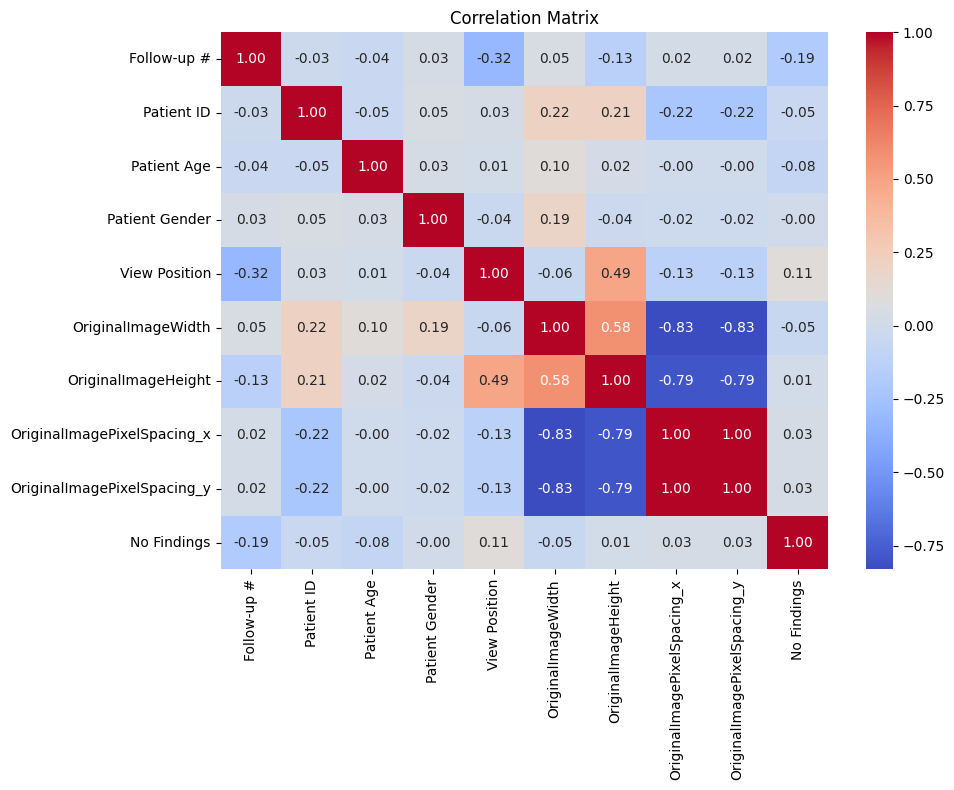

In [16]:
dataframe = df[['Follow-up #','Patient ID', 'Patient Age', 'Patient Gender','View Position','OriginalImageWidth', 'OriginalImageHeight','OriginalImagePixelSpacing_x','OriginalImagePixelSpacing_y','No Findings']]
corr_matrix = dataframe.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

Can be seen that the 'No Findings' column does not have much dependency on the other columns

### Splitting data into Train and Test sets

In [14]:
from random import shuffle

path = "/content/nih_chest_xray_sample/sample/sample/images"

train_df = df.iloc[:int(len(df) * 0.8)]
test_df = df.iloc[int(len(df) * 0.8):]

test_df.reset_index(inplace=True)
test_df.drop(columns=["index"], inplace=True)

train_paths = train_df["file_path"].tolist()
test_paths = test_df["file_path"].tolist()

print("Train Paths: ", len(train_paths))
print("Test Paths: ", len(test_paths))

Train Paths:  4484
Test Paths:  1122


<ipython-input-14-75796174286e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=["index"], inplace=True)


In [15]:
import shutil

destination_dir1 = "./nih_images/train/"
destination_dir2 = "./nih_images/test/"

for train_path in train_paths:
  try:
      # Ensure the destination directory exists
      os.makedirs(destination_dir1, exist_ok=True)

      # Copy the file
      shutil.copy(train_path, destination_dir1)
  except FileNotFoundError:
        print(f"Error: Source file not found: {train_path}")
  except Exception as e:
      print(f"An error occurred: {e}")
print(f"Image copied successfully to {destination_dir1}")

for test_path in test_paths:
  try:
      # Ensure the destination directory exists
      os.makedirs(destination_dir2, exist_ok=True)

      # Copy the file
      shutil.copy(test_path, destination_dir2)
  except FileNotFoundError:
        print(f"Error: Source file not found: {test_path}")
  except Exception as e:
      print(f"An error occurred: {e}")
print(f"Image copied successfully to {destination_dir2}")

Image copied successfully to ./nih_images/train/
Image copied successfully to ./nih_images/test/


In [16]:
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

import numpy as np

class CXRDataset(Dataset):
    def __init__(self, data, img_dir, transform=None):
        self.data = data
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_file = self.img_dir + self.data.iloc[:,0][idx]
        img = Image.open(img_file).convert('RGB')
        label = np.array(self.data.iloc[:,-1].iloc[idx])

        if self.transform:
            img = self.transform(img)

        return img, label

### Loading image data to the datasets

In [17]:
from torchvision import datasets, transforms

import torch

BATCH_SIZE = 32
NUM_CLIENTS = 5

def load_datasets(partition_id):
    transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    trainset = CXRDataset(train_df, "./nih_images/train/", transform=transform)
    testset = CXRDataset(test_df, "./nih_images/test/", transform=transform)

    partition_size = len(trainset) // NUM_CLIENTS
    diff = len(trainset) - partition_size * NUM_CLIENTS

    if diff  == 0:
      lengths = [partition_size] * NUM_CLIENTS
    else:
      lengths = [partition_size] * (NUM_CLIENTS - 1)
      lengths.append(partition_size + diff)

    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    trainloader = []
    valloader = []

    for ds in datasets:
      val_len = len(ds) // 10
      train_len = len(ds) - val_len
      lens = [train_len, val_len]

      ds_train, ds_val =  random_split(ds, lens, torch.Generator().manual_seed(42))
      trainloader.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
      valloader.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)

    if partition_id == -1: # for whole dataset (no clients - centralized model)
      trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
      testloader = DataLoader(testset, batch_size=BATCH_SIZE)

      return trainloader, testloader

    return trainloader[partition_id], valloader[partition_id], testloader

## CNN Model

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NetNIH(nn.Module):
    def __init__(self, num_classes=1):  # num_classes = 1 for binary
        super(NetNIH, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.LeakyReLU(0.01)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.LeakyReLU(0.01)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.LeakyReLU(0.01)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu4 = nn.LeakyReLU(0.01)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Calculate the flattened size based on the number of filters and the final feature map size
        # For a 224x224 input, after 4 pooling layers (each reducing size by 2), the feature map size is 224/16 = 14 hence stop
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.relu5 = nn.LeakyReLU(0.01)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 128)
        self.relu6 = nn.LeakyReLU(0.01)
        self.dropout2 = nn.Dropout(0.5)
        self.fc_out = nn.Linear(128, num_classes)
        self.sigmoid = nn.Sigmoid() if num_classes == 1 else nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))
        x = x.view(-1, 256 * 14 * 14)
        x = self.dropout1(self.relu5(self.fc1(x)))
        x = self.dropout2(self.relu6(self.fc2(x)))
        x = self.fc_out(x)
        x = self.sigmoid(x)
        return x

In [19]:
def get_gpu_memory_usage():
    #Returns GPU memory usage in MB if CUDA is available, otherwise returns None
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated(0) / (1024 * 1024)
        reserved = torch.cuda.memory_reserved(0) / (1024 * 1024)
        return f"Allocated: {allocated:.2f} MB, Reserved: {reserved:.2f} MB"
    return "CUDA not available"

In [20]:
# Defining train and test functions
def train(net, trainloader, epochs, strategy=None, global_params=None, config=None):
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    net.train()
    total_train_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()
        correct, total, epoch_loss = 0, 0, 0.0
        all_labels = []
        all_predictions = []

        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = net(images)

            loss = criterion(outputs, labels)
            if strategy == "fed_prox":
              proximal_term = 0.0
              for local_weights, global_weights in zip(net.parameters(), global_params):
                  proximal_term += (local_weights - global_weights).norm(2)
              loss += (config["proximal_mu"] / 2) * proximal_term

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * images.size(0)
            total += labels.size(0)
            predicted = (outputs.data > 0.45).float()
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy().flatten().tolist())
            all_predictions.extend(predicted.cpu().numpy().flatten().tolist())

        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total

        # Calculate precision, recall, and F1-score
        precision = precision_score(all_labels, all_predictions, zero_division=1)
        recall = recall_score(all_labels, all_predictions)
        f1 = f1_score(all_labels, all_predictions)

        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time
        print(f"Epoch: {epoch+1}/{epochs}, train loss {epoch_loss:.4f}, accuracy {epoch_acc:.4f}, precision {precision:.4f}, recall {recall:.4f}, f1-score {f1:.4f}, epoch time: {epoch_time:.4f} s, GPU Memory: {get_gpu_memory_usage()}")

    total_train_end_time = time.time()
    total_training_time = total_train_end_time - total_train_start_time
    print(f"Total Training Time: {total_training_time:.4f} seconds")

def test(net, valloader):
    criterion = torch.nn.BCELoss()
    correct, total, loss = 0, 0, 0.0
    all_labels = []
    all_predictions = []
    net.eval()
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE).float().unsqueeze(1)
            outputs = net(images)
            loss += criterion(outputs, labels).item() * images.size(0)
            predicted = (outputs.data > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy().flatten().tolist())
            all_predictions.extend(predicted.cpu().numpy().flatten().tolist())

    accuracy = correct / total
    precision = precision_score(all_labels, all_predictions,zero_division=1)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    return loss / len(valloader.dataset), accuracy, precision, recall, f1

# Centralized Learning Model

In [ ]:
trainloader, testloader = load_datasets(partition_id=-1)
net = NetNIH().to(DEVICE)

print("Using Device:", DEVICE)

train(net, trainloader, 10)

Using Device: cuda
Epoch: 1/10, train loss 0.6816, accuracy 0.5698, precision 0.5669, recall 0.9146, f1-score 0.7000, epoch time: 122.0616 s, GPU Memory: Allocated: 417.63 MB, Reserved: 2132.00 MB
Epoch: 2/10, train loss 0.6696, accuracy 0.5868, precision 0.5840, recall 0.8581, f1-score 0.6950, epoch time: 104.8816 s, GPU Memory: Allocated: 417.63 MB, Reserved: 2132.00 MB
Epoch: 3/10, train loss 0.6600, accuracy 0.5986, precision 0.5950, recall 0.8402, f1-score 0.6967, epoch time: 104.0252 s, GPU Memory: Allocated: 417.63 MB, Reserved: 2132.00 MB
Epoch: 4/10, train loss 0.6598, accuracy 0.5972, precision 0.5953, recall 0.8301, f1-score 0.6934, epoch time: 103.3503 s, GPU Memory: Allocated: 417.63 MB, Reserved: 2132.00 MB
Epoch: 5/10, train loss 0.6604, accuracy 0.6030, precision 0.5960, recall 0.8577, f1-score 0.7033, epoch time: 115.8446 s, GPU Memory: Allocated: 417.63 MB, Reserved: 2132.00 MB
Epoch: 6/10, train loss 0.6548, accuracy 0.6166, precision 0.6104, recall 0.8329, f1-score 

In [ ]:
loss, accuracy, precision, recall, f1 = test(net, testloader)
print(f"Test loss {loss}, accuracy {accuracy}, precision {precision}, recall {recall}, f1 {f1}")

Test loss 0.639896470488924, accuracy 0.6452762923351159, precision 0.6703296703296703, recall 0.6267123287671232, f1 0.647787610619469


In [ ]:
#Computing the communication overhead
def estimate_centralized_data_size(data_dir):
    """Estimates the total size of a dataset directory in bytes."""
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(data_dir):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            try:
                total_size += os.path.getsize(fp)
            except OSError as e:
                print(f"Error accessing file: {fp} - {e}")
    return total_size

train_data_directory = './nih_images/train'
centralized_communication_bytes = estimate_centralized_data_size(train_data_directory)
centralized_communication_mb = centralized_communication_bytes / (1024 * 1024)
print(f"Estimated communication overhead for centralized learning: {centralized_communication_mb:.2f} MB")

Estimated communication overhead for centralized learning: 1703.86 MB


# Decentalized Learning Models
 1. FedAvg
 2. FedProx and
 3. FedAdams

In [21]:
from sklearn.metrics import roc_auc_score
import torch
import numpy as np

def run_membership_inference_attack(model, train_loader, test_loader):
    """Evaluate privacy risk using a simple Membership Inference Attack (MIA).

    Args:
        model (torch.nn.Module): The trained global model.
        train_loader (DataLoader): Loader for member (training) data.
        test_loader (DataLoader): Loader for non-member (testing) data.

    Returns:
        float: AUC score indicating attack success (higher = worse privacy).
    """
    model.eval()
    train_confidences, test_confidences = [], []

    with torch.no_grad():
        # Collect confidence scores from the train set (members)
        for x_img, y in train_loader:
            x_img = x_img.to(DEVICE)
            output = model(x_img)
            confidence = torch.sigmoid(output).squeeze().cpu().numpy()
            train_confidences.extend(confidence)

        # Collect confidence scores from the test set (non-members)
        for x_img, y in test_loader:
            x_img = x_img.to(DEVICE)
            output = model(x_img)
            confidence = torch.sigmoid(output).squeeze().cpu().numpy()
            test_confidences.extend(confidence)

    # Labels: 1 = member, 0 = non-member
    labels = [1] * len(train_confidences) + [0] * len(test_confidences)
    scores = list(train_confidences) + list(test_confidences)

    # Compute MIA AUC
    auc = roc_auc_score(labels, scores)
    print(f"[Privacy Risk] Membership Inference Attack AUC: {auc:.4f}")

    return auc

def load_weights_into_model(model, npz_path):
    # Load the saved weights
    loaded = np.load(npz_path)
    param_list = [loaded[key] for key in loaded.files]

    # Convert to proper state_dict
    params_dict = zip(model.state_dict().keys(), param_list)
    new_state_dict = {k: torch.tensor(v) for k, v in params_dict}

    model.load_state_dict(new_state_dict, strict=True)
    print(f"Loaded weights from {npz_path} into model successfully.")
    return model

## 1. FedAvg

In [ ]:
#Functions to get parameters and set parameters
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [ ]:
#Define Client class for FedAvg
class FAClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        fit_start_time = time.time()
        train(self.net, self.trainloader, epochs=2) # train here.
        fit_end_time = time.time()
        fit_duration = fit_end_time - fit_start_time
        print(f"Client fit in {fit_duration:.2f} seconds.")
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        eval_start_time = time.time()
        loss, accuracy, precision, recall, f1  = test(self.net, self.valloader)
        eval_end_time = time.time()
        eval_duration = eval_end_time - eval_start_time
        print(f"Client eval in {eval_duration:.2f} seconds.")
        print(f"precision {precision}, recall {recall}, f1 {f1}")
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
#Create a Flower client representing a single organization
def client_fn(context: Context) -> Client:
    net = NetNIH().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)
    return FAClient(net, trainloader, valloader).to_client()

FAclient = ClientApp(client_fn=client_fn)

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
#Saves the final model and retrieves model parameters
class SaveModelStrategy(flwr.server.strategy.FedAvg):
    def aggregate_fit(
        self,
        server_round,
        results,
        failures,
    ):

        # Call aggregate_fit from base class (FedAvg) to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(
            server_round, results, failures
        )

        if aggregated_parameters is not None:
            aggregated_ndarrays: list[np.ndarray] = flwr.common.parameters_to_ndarrays(
                aggregated_parameters
            )

            print(f"FedAvg - Saving round {server_round} aggregated_ndarrays...")
            np.savez(f"FedAvg - round-{server_round}-weights.npz", *aggregated_ndarrays)

        return aggregated_parameters, aggregated_metrics


# Create strategy and pass into ServerApp
def server_fn(context):
    FAstrategy = SaveModelStrategy(
        fraction_fit=1.0,  # Sample 100% of available clients for training
        fraction_evaluate=1.0,  # Sample 100% of available clients for evaluation
        min_fit_clients=5,  # Never sample less than 5 clients for training
        min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
        min_available_clients=5,  # Wait until all 5 clients are available
        evaluate_metrics_aggregation_fn=weighted_average, # metric aggregation function
    )
    config = ServerConfig(num_rounds=5)
    return ServerAppComponents(strategy=FAstrategy, config=config)


FAserver = ServerApp(server_fn=server_fn)

In [ ]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [ ]:
# Run FL simulation
run_simulation(
    server_app=FAserver,
    client_app=FAclient,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=4505) 2025-04-25 18:11:28.996588: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=4505) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=4505) E0000 00:00:1745604689.028449    4505 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=4505) E0000 00:00:1745604689.038271    4505 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO :      Received initial parameters from one random client
INFO :      Starting 

(ClientAppActor pid=4505) Epoch: 1/2, train loss 0.7103, accuracy 0.5713, precision 0.5722, recall 0.9495, f1-score 0.7140, epoch time: 21.6298 s, GPU Memory: Allocated: 419.46 MB, Reserved: 2130.00 MB
(ClientAppActor pid=4505) Epoch: 2/2, train loss 0.6871, accuracy 0.5613, precision 0.5627, recall 0.9956, f1-score 0.7190, epoch time: 19.9284 s, GPU Memory: Allocated: 419.46 MB, Reserved: 2130.00 MB
(ClientAppActor pid=4505) Total Training Time: 41.5589 seconds
(ClientAppActor pid=4505) Client fit in 41.56 seconds.
(ClientAppActor pid=4505) Epoch: 1/2, train loss 0.7030, accuracy 0.5390, precision 0.5481, recall 0.9553, f1-score 0.6966, epoch time: 19.4051 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=4505) Epoch: 2/2, train loss 0.6878, accuracy 0.5539, precision 0.5539, recall 1.0000, f1-score 0.7129, epoch time: 19.7759 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=4505) Total Training Time: 39.1817 seconds
(ClientAppA

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


FedAvg - Saving round 1 aggregated_ndarrays...
(ClientAppActor pid=4505) Client eval in 5.19 seconds.
(ClientAppActor pid=4505) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=4505) Client eval in 2.28 seconds.
(ClientAppActor pid=4505) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=4505) Client eval in 3.37 seconds.
(ClientAppActor pid=4505) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=4505) Client eval in 2.98 seconds.
(ClientAppActor pid=4505) precision 1.0, recall 0.0, f1 0.0


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=4505) Client eval in 3.97 seconds.
(ClientAppActor pid=4505) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=4505) Epoch: 1/2, train loss 0.6936, accuracy 0.5601, precision 0.5646, recall 0.9604, f1-score 0.7111, epoch time: 18.9288 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=4505) Epoch: 2/2, train loss 0.6933, accuracy 0.5564, precision 0.5629, recall 0.9538, f1-score 0.7080, epoch time: 19.7888 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=4505) Total Training Time: 38.7183 seconds
(ClientAppActor pid=4505) Client fit in 38.72 seconds.
(ClientAppActor pid=4505) Epoch: 1/2, train loss 0.6924, accuracy 0.5527, precision 0.5535, recall 0.9955, f1-score 0.7114, epoch time: 18.7785 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=4505) Epoch: 2/2, train loss 0.6803, accuracy 0.5613, precision 0.5586, recall 0.9911, f1-score 0.7145, epoch time: 19.7181 s, GPU Memory: Al

INFO :      aggregate_fit: received 5 results and 0 failures


FedAvg - Saving round 2 aggregated_ndarrays...


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=4505) Client eval in 1.93 seconds.
(ClientAppActor pid=4505) precision 0.6067415730337079, recall 1.0, f1 0.7552447552447552
(ClientAppActor pid=4505) Client eval in 1.88 seconds.
(ClientAppActor pid=4505) precision 0.5617977528089888, recall 1.0, f1 0.7194244604316546
(ClientAppActor pid=4505) Client eval in 2.53 seconds.
(ClientAppActor pid=4505) precision 0.5280898876404494, recall 1.0, f1 0.6911764705882353
(ClientAppActor pid=4505) Client eval in 1.91 seconds.
(ClientAppActor pid=4505) precision 0.550561797752809, recall 1.0, f1 0.7101449275362319


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=4505) Client eval in 1.85 seconds.
(ClientAppActor pid=4505) precision 0.5, recall 1.0, f1 0.6666666666666666
(ClientAppActor pid=4505) Epoch: 1/2, train loss 0.6782, accuracy 0.5849, precision 0.5817, recall 0.9385, f1-score 0.7183, epoch time: 19.0222 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=4505) Epoch: 2/2, train loss 0.6789, accuracy 0.5960, precision 0.5961, recall 0.8791, f1-score 0.7105, epoch time: 19.8048 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=4505) Total Training Time: 38.8280 seconds
(ClientAppActor pid=4505) Client fit in 38.83 seconds.
(ClientAppActor pid=4505) Epoch: 1/2, train loss 0.7038, accuracy 0.5502, precision 0.5572, recall 0.9150, f1-score 0.6926, epoch time: 18.9900 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=4505) Epoch: 2/2, train loss 0.6758, accuracy 0.5551, precision 0.5580, recall 0.9463, f1-score 0.7021, epoch time: 19.5834 s,

INFO :      aggregate_fit: received 5 results and 0 failures


FedAvg - Saving round 3 aggregated_ndarrays...


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=4505) Client eval in 1.87 seconds.
(ClientAppActor pid=4505) precision 0.6219512195121951, recall 0.9444444444444444, f1 0.75
(ClientAppActor pid=4505) Client eval in 2.24 seconds.
(ClientAppActor pid=4505) precision 0.5657894736842105, recall 0.86, f1 0.6825396825396826
(ClientAppActor pid=4505) Client eval in 2.27 seconds.
(ClientAppActor pid=4505) precision 0.5789473684210527, recall 0.9361702127659575, f1 0.7154471544715447
(ClientAppActor pid=4505) Client eval in 1.81 seconds.
(ClientAppActor pid=4505) precision 0.6052631578947368, recall 0.9387755102040817, f1 0.736


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=4505) Client eval in 1.85 seconds.
(ClientAppActor pid=4505) precision 0.5584415584415584, recall 0.9555555555555556, f1 0.7049180327868853
(ClientAppActor pid=4505) Epoch: 1/2, train loss 0.6702, accuracy 0.5787, precision 0.5782, recall 0.9341, f1-score 0.7143, epoch time: 19.7804 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=4505) Epoch: 2/2, train loss 0.6574, accuracy 0.6283, precision 0.6224, recall 0.8659, f1-score 0.7243, epoch time: 18.8517 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=4505) Total Training Time: 38.6330 seconds
(ClientAppActor pid=4505) Client fit in 38.63 seconds.
(ClientAppActor pid=4505) Epoch: 1/2, train loss 0.6873, accuracy 0.5576, precision 0.5565, recall 0.9911, f1-score 0.7128, epoch time: 23.3627 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=4505) Epoch: 2/2, train loss 0.6719, accuracy 0.5849, precision 0.5862, recall 0.8523, f1-score 

INFO :      aggregate_fit: received 5 results and 0 failures


FedAvg - Saving round 4 aggregated_ndarrays...


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=4505) Client eval in 3.32 seconds.
(ClientAppActor pid=4505) precision 0.7192982456140351, recall 0.7592592592592593, f1 0.7387387387387387
(ClientAppActor pid=4505) Client eval in 2.22 seconds.
(ClientAppActor pid=4505) precision 0.5862068965517241, recall 0.68, f1 0.6296296296296297
(ClientAppActor pid=4505) Client eval in 2.16 seconds.
(ClientAppActor pid=4505) precision 0.6666666666666666, recall 0.851063829787234, f1 0.7476635514018691
(ClientAppActor pid=4505) Client eval in 1.80 seconds.
(ClientAppActor pid=4505) precision 0.6666666666666666, recall 0.7346938775510204, f1 0.6990291262135923


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=4505) Client eval in 1.88 seconds.
(ClientAppActor pid=4505) precision 0.6724137931034483, recall 0.8666666666666667, f1 0.7572815533980582
(ClientAppActor pid=4505) Epoch: 1/2, train loss 0.6643, accuracy 0.6022, precision 0.5952, recall 0.9209, f1-score 0.7230, epoch time: 22.5686 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=4505) Epoch: 2/2, train loss 0.6615, accuracy 0.6146, precision 0.6111, recall 0.8703, f1-score 0.7180, epoch time: 28.3002 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=4505) Total Training Time: 50.8697 seconds
(ClientAppActor pid=4505) Client fit in 50.87 seconds.
(ClientAppActor pid=4505) Epoch: 1/2, train loss 0.6695, accuracy 0.5774, precision 0.5786, recall 0.8725, f1-score 0.6958, epoch time: 21.8223 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=4505) Epoch: 2/2, train loss 0.6639, accuracy 0.5923, precision 0.5952, recall 0.8255, f1-score 

INFO :      aggregate_fit: received 5 results and 0 failures


FedAvg - Saving round 5 aggregated_ndarrays...


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=4505) Client eval in 1.91 seconds.
(ClientAppActor pid=4505) precision 0.75, recall 0.7222222222222222, f1 0.7358490566037735
(ClientAppActor pid=4505) Client eval in 1.84 seconds.
(ClientAppActor pid=4505) precision 0.6, recall 0.66, f1 0.6285714285714286
(ClientAppActor pid=4505) Client eval in 1.97 seconds.
(ClientAppActor pid=4505) precision 0.6842105263157895, recall 0.8297872340425532, f1 0.75
(ClientAppActor pid=4505) Client eval in 2.45 seconds.
(ClientAppActor pid=4505) precision 0.6491228070175439, recall 0.7551020408163265, f1 0.6981132075471698


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 1109.76s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.6933144755458713
INFO :      		round 2: 0.6898562476876078
INFO :      		round 3: 0.683060664041212
INFO :      		round 4: 0.6696814134028668
INFO :      		round 5: 0.6572235459245547
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.45056179775280897),
INFO :      	              (2, 0.5494382022471911),
INFO :      	              (3, 0.6008988764044944),
INFO :      	              (4, 0.6590511860174783),
INFO :      	              (5, 0.6613233458177278)]}
INFO :      


(ClientAppActor pid=4505) Client eval in 1.87 seconds.
(ClientAppActor pid=4505) precision 0.6610169491525424, recall 0.8666666666666667, f1 0.75


In [ ]:
#Estimates the size of a PyTorch model in bytes
def estimate_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.numel() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.numel() * buffer.element_size()
    return param_size + buffer_size

binary_model = NetNIH().to(DEVICE)
model_size_bytes = estimate_model_size(binary_model)
model_size_mb = model_size_bytes / (1024 * 1024)
num_rounds = 5
num_clients = NUM_CLIENTS

uplink_per_round_bytes = num_clients * model_size_bytes
downlink_per_round_bytes = num_clients * model_size_bytes
total_uplink_bytes = num_rounds * uplink_per_round_bytes
total_downlink_bytes = num_rounds * downlink_per_round_bytes
total_communication_bytes = total_uplink_bytes + total_downlink_bytes

uplink_mb = total_uplink_bytes / (1024 * 1024)
downlink_mb = total_downlink_bytes / (1024 * 1024)
total_mb = total_communication_bytes / (1024 * 1024)

print("\n--- Federated Learning Communication Overhead Estimation ---")
print(f"Estimated model size: {model_size_mb:.2f} MB")
print(f"Number of clients: {num_clients}")
print(f"Number of rounds: {num_rounds}")
print(f"Estimated uplink communication (total): {uplink_mb:.2f} MB")
print(f"Estimated downlink communication (total): {downlink_mb:.2f} MB")
print(f"Estimated total communication: {total_mb:.2f} MB")


--- Federated Learning Communication Overhead Estimation ---
Estimated model size: 99.73 MB
Number of clients: 5
Number of rounds: 5
Estimated uplink communication (total): 2493.37 MB
Estimated downlink communication (total): 2493.37 MB
Estimated total communication: 4986.73 MB


In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the full centralized train dataset
central_trainset = CXRDataset(train_df, "./nih_images/train/", transform=transform)

# Create the full test dataset
central_testset = CXRDataset(test_df, "./nih_images/test/", transform=transform)

# Now, DataLoaders
central_train_loader = DataLoader(central_trainset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(central_testset, batch_size=BATCH_SIZE, shuffle=False)

# Step 1: Rebuild model
global_model = NetNIH().to(DEVICE)

# Step 2: Load saved weights
global_model = load_weights_into_model(global_model, "/content/FedAvg - round-5-weights.npz")

# Step 3: Run MIA
mia_auc = run_membership_inference_attack(global_model, central_train_loader, test_loader)
print(f"Membership Inference Attack AUC: {mia_auc:.4f}")

Loaded weights from /content/FedAvg - round-5-weights.npz into model successfully.
[Privacy Risk] Membership Inference Attack AUC: 0.5190
Membership Inference Attack AUC: 0.5190


## 1. FedAvg-DP

In [25]:
#Functions to get parameters and set parameters
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [26]:
#Define Client class for FedAvg
class FAClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        fit_start_time = time.time()
        train(self.net, self.trainloader, epochs=2) # train here.
        fit_end_time = time.time()
        fit_duration = fit_end_time - fit_start_time
        print(f"Client fit in {fit_duration:.2f} seconds.")
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        eval_start_time = time.time()
        loss, accuracy, precision, recall, f1  = test(self.net, self.valloader)
        eval_end_time = time.time()
        eval_duration = eval_end_time - eval_start_time
        print(f"Client eval in {eval_duration:.2f} seconds.")
        print(f"precision {precision}, recall {recall}, f1 {f1}")
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [27]:
#Create a Flower client representing a single organization
def client_fn(context: Context) -> Client:
    net = NetNIH().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)
    return FAClient(net, trainloader, valloader).to_client()

FAclient = ClientApp(client_fn=client_fn, mods=[fixedclipping_mod])

In [28]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [38]:
#Saves the final model and retrieves model parameters
class SaveModelStrategy(flwr.server.strategy.FedAvg):
    def aggregate_fit(
        self,
        server_round,
        results,
        failures,
    ):

        # Call aggregate_fit from base class (FedAvg) to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(
            server_round, results, failures
        )

        if aggregated_parameters is not None:
            aggregated_ndarrays: list[np.ndarray] = flwr.common.parameters_to_ndarrays(
                aggregated_parameters
            )

            print(f"FedAvg-DP - Saving round {server_round} aggregated_ndarrays...")
            np.savez(f"FedAvg-DP - round-{server_round}-weights.npz", *aggregated_ndarrays)

        return aggregated_parameters, aggregated_metrics


# Create strategy and pass into ServerApp
def server_fn(context):
    FAstrategy = SaveModelStrategy(
        fraction_fit=1.0,  # Sample 100% of available clients for training
        fraction_evaluate=1.0,  # Sample 100% of available clients for evaluation
        min_fit_clients=5,  # Never sample less than 5 clients for training
        min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
        min_available_clients=5,  # Wait until all 5 clients are available
        evaluate_metrics_aggregation_fn=weighted_average, # metric aggregation function
    )

    # === Wrap in client-side DP fixed clipping ===
    dp_strategy = DifferentialPrivacyClientSideFixedClipping(
        FAstrategy,
        noise_multiplier=1.0,    # σ (tune as needed)
        clipping_norm=1.0,       # C (tune as needed)
        num_sampled_clients=5,   # number of clients per round
    )
    config = ServerConfig(num_rounds=5)
    return ServerAppComponents(strategy=dp_strategy, config=config)


FAserver = ServerApp(server_fn=server_fn)

In [39]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [40]:
# Run FL simulation
run_simulation(
    server_app=FAserver,
    client_app=FAclient,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=31363) 2025-04-26 02:52:35.805172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=31363) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=31363) E0000 00:00:1745635955.907488   31363 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=31363) E0000 00:00:1745635955.917692   31363 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INF

(ClientAppActor pid=31363) Epoch: 1/2, train loss 0.7041, accuracy 0.5465, precision 0.5574, recall 0.9495, f1-score 0.7024, epoch time: 21.4641 s, GPU Memory: Allocated: 419.46 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Epoch: 2/2, train loss 0.6805, accuracy 0.5626, precision 0.5634, recall 0.9956, f1-score 0.7196, epoch time: 20.2843 s, GPU Memory: Allocated: 419.46 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Total Training Time: 41.7493 seconds
(ClientAppActor pid=31363) Client fit in 41.75 seconds.


(ClientAppActor pid=31363) INFO :      fixedclipping_mod: parameters are clipped by value: 1.0000.


(ClientAppActor pid=31363) Epoch: 1/2, train loss 0.7064, accuracy 0.5415, precision 0.5501, recall 0.9463, f1-score 0.6957, epoch time: 21.3251 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Epoch: 2/2, train loss 0.6947, accuracy 0.5551, precision 0.5550, recall 0.9933, f1-score 0.7121, epoch time: 20.0432 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Total Training Time: 41.3713 seconds
(ClientAppActor pid=31363) Client fit in 41.37 seconds.


(ClientAppActor pid=31363) INFO :      fixedclipping_mod: parameters are clipped by value: 1.0000.


(ClientAppActor pid=31363) Epoch: 1/2, train loss 0.7775, accuracy 0.5328, precision 0.5380, recall 0.9145, f1-score 0.6775, epoch time: 22.4340 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Epoch: 2/2, train loss 0.6850, accuracy 0.5353, precision 0.5364, recall 0.9861, f1-score 0.6949, epoch time: 19.0320 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Total Training Time: 41.4670 seconds
(ClientAppActor pid=31363) Client fit in 41.47 seconds.


(ClientAppActor pid=31363) INFO :      fixedclipping_mod: parameters are clipped by value: 1.0000.


(ClientAppActor pid=31363) Epoch: 1/2, train loss 0.6921, accuracy 0.5638, precision 0.5602, recall 0.8611, f1-score 0.6788, epoch time: 20.8957 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Epoch: 2/2, train loss 0.6740, accuracy 0.5874, precision 0.5855, recall 0.7847, f1-score 0.6706, epoch time: 18.8571 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Total Training Time: 39.7535 seconds
(ClientAppActor pid=31363) Client fit in 39.75 seconds.


(ClientAppActor pid=31363) INFO :      fixedclipping_mod: parameters are clipped by value: 1.0000.


(ClientAppActor pid=31363) Epoch: 1/2, train loss 0.7022, accuracy 0.5519, precision 0.5544, recall 0.9665, f1-score 0.7046, epoch time: 20.7383 s, GPU Memory: Allocated: 420.94 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Epoch: 2/2, train loss 0.6870, accuracy 0.5506, precision 0.5534, recall 0.9710, f1-score 0.7050, epoch time: 18.9481 s, GPU Memory: Allocated: 420.94 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Total Training Time: 39.6872 seconds
(ClientAppActor pid=31363) Client fit in 39.69 seconds.


(ClientAppActor pid=31363) INFO :      fixedclipping_mod: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: received 5 results and 0 failures


FedAvg-DP - Saving round 1 aggregated_ndarrays...


INFO :      aggregate_fit: central DP noise with 0.2000 stdev added
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=31363) Client eval in 1.92 seconds.
(ClientAppActor pid=31363) precision 0.6231884057971014, recall 0.7962962962962963, f1 0.6991869918699187
(ClientAppActor pid=31363) Client eval in 1.90 seconds.
(ClientAppActor pid=31363) precision 0.5416666666666666, recall 0.78, f1 0.639344262295082
(ClientAppActor pid=31363) Client eval in 1.93 seconds.
(ClientAppActor pid=31363) precision 0.5205479452054794, recall 0.8085106382978723, f1 0.6333333333333333
(ClientAppActor pid=31363) Client eval in 1.91 seconds.
(ClientAppActor pid=31363) precision 0.5974025974025974, recall 0.9387755102040817, f1 0.7301587301587301


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=31363) Client eval in 2.73 seconds.
(ClientAppActor pid=31363) precision 0.49295774647887325, recall 0.7777777777777778, f1 0.603448275862069
(ClientAppActor pid=31363) Epoch: 1/2, train loss 50.1232, accuracy 0.4981, precision 0.5749, recall 0.4220, f1-score 0.4867, epoch time: 18.8921 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Epoch: 2/2, train loss 54.8947, accuracy 0.4511, precision 0.5667, recall 0.1121, f1-score 0.1872, epoch time: 20.0266 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Total Training Time: 38.9194 seconds
(ClientAppActor pid=31363) Client fit in 38.92 seconds.


(ClientAppActor pid=31363) INFO :      fixedclipping_mod: parameters are clipped by value: 1.0000.


(ClientAppActor pid=31363) Epoch: 1/2, train loss 47.7725, accuracy 0.5217, precision 0.5639, recall 0.6018, f1-score 0.5823, epoch time: 18.8193 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Epoch: 2/2, train loss 47.3358, accuracy 0.5266, precision 0.5476, recall 0.8367, f1-score 0.6619, epoch time: 19.7997 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Total Training Time: 38.6197 seconds
(ClientAppActor pid=31363) Client fit in 38.62 seconds.


(ClientAppActor pid=31363) INFO :      fixedclipping_mod: parameters are clipped by value: 1.0000.


(ClientAppActor pid=31363) Epoch: 1/2, train loss 46.5923, accuracy 0.5341, precision 0.5610, recall 0.6051, f1-score 0.5822, epoch time: 18.8520 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Epoch: 2/2, train loss 51.0533, accuracy 0.4895, precision 0.5238, recall 0.5335, f1-score 0.5286, epoch time: 19.8162 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Total Training Time: 38.6689 seconds
(ClientAppActor pid=31363) Client fit in 38.67 seconds.


(ClientAppActor pid=31363) INFO :      fixedclipping_mod: parameters are clipped by value: 1.0000.


(ClientAppActor pid=31363) Epoch: 1/2, train loss 49.0706, accuracy 0.5093, precision 0.5435, recall 0.5208, f1-score 0.5319, epoch time: 18.8310 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Epoch: 2/2, train loss 52.1685, accuracy 0.4783, precision 0.5364, recall 0.1875, f1-score 0.2779, epoch time: 19.7507 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Total Training Time: 38.5825 seconds
(ClientAppActor pid=31363) Client fit in 38.58 seconds.


(ClientAppActor pid=31363) INFO :      fixedclipping_mod: parameters are clipped by value: 1.0000.


(ClientAppActor pid=31363) Epoch: 1/2, train loss 51.4822, accuracy 0.4852, precision 0.5838, recall 0.2411, f1-score 0.3412, epoch time: 18.7841 s, GPU Memory: Allocated: 420.94 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Epoch: 2/2, train loss 54.4444, accuracy 0.4556, precision 0.5455, recall 0.0938, f1-score 0.1600, epoch time: 19.7332 s, GPU Memory: Allocated: 420.94 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Total Training Time: 38.5183 seconds
(ClientAppActor pid=31363) Client fit in 38.52 seconds.


(ClientAppActor pid=31363) INFO :      fixedclipping_mod: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: received 5 results and 0 failures


FedAvg-DP - Saving round 2 aggregated_ndarrays...


INFO :      aggregate_fit: central DP noise with 0.2000 stdev added
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=31363) Client eval in 1.82 seconds.
(ClientAppActor pid=31363) precision 0.6067415730337079, recall 1.0, f1 0.7552447552447552
(ClientAppActor pid=31363) Client eval in 1.84 seconds.
(ClientAppActor pid=31363) precision 0.5568181818181818, recall 0.98, f1 0.7101449275362319
(ClientAppActor pid=31363) Client eval in 2.60 seconds.
(ClientAppActor pid=31363) precision 0.5287356321839081, recall 0.9787234042553191, f1 0.6865671641791045
(ClientAppActor pid=31363) Client eval in 1.86 seconds.
(ClientAppActor pid=31363) precision 0.5454545454545454, recall 0.9795918367346939, f1 0.7007299270072993


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=31363) Client eval in 1.86 seconds.
(ClientAppActor pid=31363) precision 0.5, recall 0.9777777777777777, f1 0.6616541353383458
(ClientAppActor pid=31363) Epoch: 1/2, train loss 46.4684, accuracy 0.5353, precision 0.5738, recall 0.6835, f1-score 0.6239, epoch time: 19.0023 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Epoch: 2/2, train loss 47.0880, accuracy 0.5291, precision 0.5712, recall 0.6615, f1-score 0.6130, epoch time: 19.6633 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Total Training Time: 38.6664 seconds
(ClientAppActor pid=31363) Client fit in 38.67 seconds.


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=31363, ip=172.28.0.12, actor_id=7627faab50fef30fe0bdb71f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x79ab9631d9d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/mod/utils.py", line 27, in new_ffn
    return _mod(message, context, _ffn)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/mod/centraldp_mods.py", line 79, in fixedclipping_mod
    compute_clip_model_update(
  File "/usr/local/lib/python3.11/dist-packages/flwr/common/differential_privacy.py", line 74, in compute_clip_model_update
    clip_inputs_inplace(model_update, clipping_no

(ClientAppActor pid=31363) Epoch: 1/2, train loss 47.4597, accuracy 0.5254, precision 0.5599, recall 0.6689, f1-score 0.6096, epoch time: 18.7892 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Epoch: 2/2, train loss 49.0706, accuracy 0.5093, precision 0.5471, recall 0.6622, f1-score 0.5992, epoch time: 19.7505 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Total Training Time: 38.5406 seconds
(ClientAppActor pid=31363) Client fit in 38.54 seconds.


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=31363, ip=172.28.0.12, actor_id=7627faab50fef30fe0bdb71f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x79ab9631d9d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/mod/utils.py", line 27, in new_ffn
    return _mod(message, context, _ffn)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/mod/centraldp_mods.py", line 79, in fixedclipping_mod
    compute_clip_model_update(
  File "/usr/local/lib/python3.11/dist-packages/flwr/common/differential_privacy.py", line 74, in compute_clip_model_update
    clip_inputs_inplace(model_update, clipping_no

(ClientAppActor pid=31363) Epoch: 1/2, train loss 47.9554, accuracy 0.5204, precision 0.5434, recall 0.6651, f1-score 0.5981, epoch time: 18.8320 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=31363, ip=172.28.0.12, actor_id=7627faab50fef30fe0bdb71f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x79ab9631d9d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/mod/utils.py", line 27, in new_ffn
    return _mod(message, context, _ffn)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/mod/centraldp_mods.py", line 79, in fixedclipping_mod
    compute_clip_model_update(
  File "/usr/local/lib/python3.11/dist-packages/flwr/common/differential_privacy.py", line 74, in compute_clip_model_update
    clip_inputs_inplace(model_update, clipping_no

(ClientAppActor pid=31363) Epoch: 2/2, train loss 45.9727, accuracy 0.5403, precision 0.5572, recall 0.6975, f1-score 0.6195, epoch time: 19.6945 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Total Training Time: 38.5273 seconds
(ClientAppActor pid=31363) Client fit in 38.53 seconds.
(ClientAppActor pid=31363) Epoch: 1/2, train loss 49.0706, accuracy 0.5093, precision 0.5332, recall 0.6690, f1-score 0.5934, epoch time: 18.8410 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Epoch: 2/2, train loss 47.4597, accuracy 0.5254, precision 0.5468, recall 0.6620, f1-score 0.5990, epoch time: 19.7901 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Total Training Time: 38.6319 seconds
(ClientAppActor pid=31363) Client fit in 38.63 seconds.


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=31363, ip=172.28.0.12, actor_id=7627faab50fef30fe0bdb71f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x79ab9631d9d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/mod/utils.py", line 27, in new_ffn
    return _mod(message, context, _ffn)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/mod/centraldp_mods.py", line 79, in fixedclipping_mod
    compute_clip_model_update(
  File "/usr/local/lib/python3.11/dist-packages/flwr/common/differential_privacy.py", line 74, in compute_clip_model_update
    clip_inputs_inplace(model_update, clipping_no

(ClientAppActor pid=31363) Epoch: 1/2, train loss 49.0123, accuracy 0.5099, precision 0.5466, recall 0.6674, f1-score 0.6010, epoch time: 19.7512 s, GPU Memory: Allocated: 420.94 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Epoch: 2/2, train loss 44.8148, accuracy 0.5519, precision 0.5758, recall 0.7210, f1-score 0.6402, epoch time: 20.0136 s, GPU Memory: Allocated: 420.94 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Total Training Time: 39.7672 seconds
(ClientAppActor pid=31363) Client fit in 39.77 seconds.


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=31363, ip=172.28.0.12, actor_id=7627faab50fef30fe0bdb71f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x79ab9631d9d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/mod/utils.py", line 27, in new_ffn
    return _mod(message, context, _ffn)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/mod/centraldp_mods.py", line 79, in fixedclipping_mod
    compute_clip_model_update(
  File "/usr/local/lib/python3.11/dist-packages/flwr/common/differential_privacy.py", line 74, in compute_clip_model_update
    clip_inputs_inplace(model_update, clipping_no

(ClientAppActor pid=31363) Client eval in 1.92 seconds.
(ClientAppActor pid=31363) precision 0.6067415730337079, recall 1.0, f1 0.7552447552447552
(ClientAppActor pid=31363) Client eval in 1.87 seconds.
(ClientAppActor pid=31363) precision 0.5568181818181818, recall 0.98, f1 0.7101449275362319
(ClientAppActor pid=31363) Client eval in 2.89 seconds.
(ClientAppActor pid=31363) precision 0.5287356321839081, recall 0.9787234042553191, f1 0.6865671641791045
(ClientAppActor pid=31363) Client eval in 1.86 seconds.
(ClientAppActor pid=31363) precision 0.5454545454545454, recall 0.9795918367346939, f1 0.7007299270072993


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=31363) Client eval in 1.95 seconds.
(ClientAppActor pid=31363) precision 0.5, recall 0.9777777777777777, f1 0.6616541353383458
(ClientAppActor pid=31363) Epoch: 1/2, train loss 46.3445, accuracy 0.5366, precision 0.5732, recall 0.6967, f1-score 0.6290, epoch time: 19.8977 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Epoch: 2/2, train loss 48.9467, accuracy 0.5105, precision 0.5556, recall 0.6593, f1-score 0.6030, epoch time: 19.2919 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Total Training Time: 39.1906 seconds
(ClientAppActor pid=31363) Client fit in 39.19 seconds.


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=31363, ip=172.28.0.12, actor_id=7627faab50fef30fe0bdb71f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x79ab9631d9d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/mod/utils.py", line 27, in new_ffn
    return _mod(message, context, _ffn)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/mod/centraldp_mods.py", line 79, in fixedclipping_mod
    compute_clip_model_update(
  File "/usr/local/lib/python3.11/dist-packages/flwr/common/differential_privacy.py", line 74, in compute_clip_model_update
    clip_inputs_inplace(model_update, clipping_no

(ClientAppActor pid=31363) Epoch: 1/2, train loss 46.3445, accuracy 0.5366, precision 0.5680, recall 0.6823, f1-score 0.6199, epoch time: 19.4453 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Epoch: 2/2, train loss 47.8315, accuracy 0.5217, precision 0.5574, recall 0.6622, f1-score 0.6053, epoch time: 19.2947 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Total Training Time: 38.7410 seconds
(ClientAppActor pid=31363) Client fit in 38.74 seconds.


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=31363, ip=172.28.0.12, actor_id=7627faab50fef30fe0bdb71f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x79ab9631d9d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/mod/utils.py", line 27, in new_ffn
    return _mod(message, context, _ffn)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/mod/centraldp_mods.py", line 79, in fixedclipping_mod
    compute_clip_model_update(
  File "/usr/local/lib/python3.11/dist-packages/flwr/common/differential_privacy.py", line 74, in compute_clip_model_update
    clip_inputs_inplace(model_update, clipping_no

(ClientAppActor pid=31363) Epoch: 1/2, train loss 46.4684, accuracy 0.5353, precision 0.5569, recall 0.6559, f1-score 0.6023, epoch time: 19.5469 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=31363, ip=172.28.0.12, actor_id=7627faab50fef30fe0bdb71f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x79ab9631d9d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/mod/utils.py", line 27, in new_ffn
    return _mod(message, context, _ffn)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/mod/centraldp_mods.py", line 79, in fixedclipping_mod
    compute_clip_model_update(
  File "/usr/local/lib/python3.11/dist-packages/flwr/common/differential_privacy.py", line 74, in compute_clip_model_update
    clip_inputs_inplace(model_update, clipping_no

(ClientAppActor pid=31363) Epoch: 2/2, train loss 47.4597, accuracy 0.5254, precision 0.5463, recall 0.6813, f1-score 0.6064, epoch time: 19.2028 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Total Training Time: 38.7505 seconds
(ClientAppActor pid=31363) Client fit in 38.75 seconds.
(ClientAppActor pid=31363) Epoch: 1/2, train loss 48.6989, accuracy 0.5130, precision 0.5353, recall 0.6852, f1-score 0.6010, epoch time: 19.4468 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Epoch: 2/2, train loss 48.3271, accuracy 0.5167, precision 0.5378, recall 0.6921, f1-score 0.6053, epoch time: 19.1894 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Total Training Time: 38.6371 seconds
(ClientAppActor pid=31363) Client fit in 38.64 seconds.


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=31363, ip=172.28.0.12, actor_id=7627faab50fef30fe0bdb71f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x79ab9631d9d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/mod/utils.py", line 27, in new_ffn
    return _mod(message, context, _ffn)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/mod/centraldp_mods.py", line 79, in fixedclipping_mod
    compute_clip_model_update(
  File "/usr/local/lib/python3.11/dist-packages/flwr/common/differential_privacy.py", line 74, in compute_clip_model_update
    clip_inputs_inplace(model_update, clipping_no

(ClientAppActor pid=31363) Epoch: 1/2, train loss 49.2593, accuracy 0.5074, precision 0.5453, recall 0.6585, f1-score 0.5966, epoch time: 19.4070 s, GPU Memory: Allocated: 420.94 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Epoch: 2/2, train loss 49.7575, accuracy 0.5012, precision 0.5470, recall 0.5714, f1-score 0.5590, epoch time: 19.4336 s, GPU Memory: Allocated: 420.94 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Total Training Time: 38.8415 seconds
(ClientAppActor pid=31363) Client fit in 38.84 seconds.


(ClientAppActor pid=31363) INFO :      fixedclipping_mod: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: received 1 results and 4 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=31363) Client eval in 1.82 seconds.
(ClientAppActor pid=31363) precision 0.6067415730337079, recall 1.0, f1 0.7552447552447552
(ClientAppActor pid=31363) Client eval in 2.04 seconds.
(ClientAppActor pid=31363) precision 0.5568181818181818, recall 0.98, f1 0.7101449275362319
(ClientAppActor pid=31363) Client eval in 2.41 seconds.
(ClientAppActor pid=31363) precision 0.5287356321839081, recall 0.9787234042553191, f1 0.6865671641791045
(ClientAppActor pid=31363) Client eval in 1.82 seconds.
(ClientAppActor pid=31363) precision 0.5454545454545454, recall 0.9795918367346939, f1 0.7007299270072993


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=31363) Client eval in 1.83 seconds.
(ClientAppActor pid=31363) precision 0.5, recall 0.9777777777777777, f1 0.6616541353383458
(ClientAppActor pid=31363) Epoch: 1/2, train loss 43.8662, accuracy 0.5613, precision 0.5947, recall 0.6967, f1-score 0.6417, epoch time: 19.8648 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Epoch: 2/2, train loss 46.2206, accuracy 0.5378, precision 0.5756, recall 0.6857, f1-score 0.6259, epoch time: 19.0433 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Total Training Time: 38.9090 seconds
(ClientAppActor pid=31363) Client fit in 38.91 seconds.


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=31363, ip=172.28.0.12, actor_id=7627faab50fef30fe0bdb71f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x79ab9631d9d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/mod/utils.py", line 27, in new_ffn
    return _mod(message, context, _ffn)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/mod/centraldp_mods.py", line 79, in fixedclipping_mod
    compute_clip_model_update(
  File "/usr/local/lib/python3.11/dist-packages/flwr/common/differential_privacy.py", line 74, in compute_clip_model_update
    clip_inputs_inplace(model_update, clipping_no

(ClientAppActor pid=31363) Epoch: 1/2, train loss 46.7162, accuracy 0.5328, precision 0.5681, recall 0.6532, f1-score 0.6077, epoch time: 19.7606 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Epoch: 2/2, train loss 48.0114, accuracy 0.5192, precision 0.5539, recall 0.6779, f1-score 0.6097, epoch time: 18.8452 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Total Training Time: 38.6069 seconds
(ClientAppActor pid=31363) Client fit in 38.61 seconds.


(ClientAppActor pid=31363) INFO :      fixedclipping_mod: parameters are clipped by value: 1.0000.


(ClientAppActor pid=31363) Epoch: 1/2, train loss 49.1945, accuracy 0.5081, precision 0.5330, recall 0.6721, f1-score 0.5945, epoch time: 19.8112 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Epoch: 2/2, train loss 48.8228, accuracy 0.5118, precision 0.5367, recall 0.6582, f1-score 0.5913, epoch time: 18.9924 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Total Training Time: 38.8044 seconds
(ClientAppActor pid=31363) Client fit in 38.80 seconds.


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=31363, ip=172.28.0.12, actor_id=7627faab50fef30fe0bdb71f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x79ab9631d9d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/mod/utils.py", line 27, in new_ffn
    return _mod(message, context, _ffn)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/mod/centraldp_mods.py", line 79, in fixedclipping_mod
    compute_clip_model_update(
  File "/usr/local/lib/python3.11/dist-packages/flwr/common/differential_privacy.py", line 74, in compute_clip_model_update
    clip_inputs_inplace(model_update, clipping_no

(ClientAppActor pid=31363) Epoch: 1/2, train loss 48.8228, accuracy 0.5118, precision 0.5347, recall 0.6782, f1-score 0.5980, epoch time: 20.0900 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=31363, ip=172.28.0.12, actor_id=7627faab50fef30fe0bdb71f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x79ab9631d9d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/mod/utils.py", line 27, in new_ffn
    return _mod(message, context, _ffn)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/mod/centraldp_mods.py", line 79, in fixedclipping_mod
    compute_clip_model_update(
  File "/usr/local/lib/python3.11/dist-packages/flwr/common/differential_privacy.py", line 74, in compute_clip_model_update
    clip_inputs_inplace(model_update, clipping_no

(ClientAppActor pid=31363) Epoch: 2/2, train loss 45.7249, accuracy 0.5428, precision 0.5595, recall 0.6852, f1-score 0.6160, epoch time: 19.2173 s, GPU Memory: Allocated: 419.42 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Total Training Time: 39.3081 seconds
(ClientAppActor pid=31363) Client fit in 39.31 seconds.
(ClientAppActor pid=31363) Epoch: 1/2, train loss 49.0123, accuracy 0.5099, precision 0.5468, recall 0.6652, f1-score 0.6002, epoch time: 20.7364 s, GPU Memory: Allocated: 420.94 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Epoch: 2/2, train loss 48.0247, accuracy 0.5198, precision 0.5558, recall 0.6562, f1-score 0.6018, epoch time: 19.2456 s, GPU Memory: Allocated: 420.94 MB, Reserved: 2130.00 MB
(ClientAppActor pid=31363) Total Training Time: 39.9829 seconds
(ClientAppActor pid=31363) Client fit in 39.98 seconds.


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=31363, ip=172.28.0.12, actor_id=7627faab50fef30fe0bdb71f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x79ab9631d9d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/mod/utils.py", line 27, in new_ffn
    return _mod(message, context, _ffn)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/mod/centraldp_mods.py", line 79, in fixedclipping_mod
    compute_clip_model_update(
  File "/usr/local/lib/python3.11/dist-packages/flwr/common/differential_privacy.py", line 74, in compute_clip_model_update
    clip_inputs_inplace(model_update, clipping_no

(ClientAppActor pid=31363) Client eval in 1.95 seconds.
(ClientAppActor pid=31363) precision 0.6067415730337079, recall 1.0, f1 0.7552447552447552
(ClientAppActor pid=31363) Client eval in 2.67 seconds.
(ClientAppActor pid=31363) precision 0.5568181818181818, recall 0.98, f1 0.7101449275362319
(ClientAppActor pid=31363) Client eval in 1.88 seconds.
(ClientAppActor pid=31363) precision 0.5287356321839081, recall 0.9787234042553191, f1 0.6865671641791045
(ClientAppActor pid=31363) Client eval in 1.84 seconds.
(ClientAppActor pid=31363) precision 0.5454545454545454, recall 0.9795918367346939, f1 0.7007299270072993


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 1078.58s
INFO :      	History (loss, distributed):
INFO :      		round 1: 45.34014712387257
INFO :      		round 2: 45.5056180114365
INFO :      		round 3: 45.50561801143652
INFO :      		round 4: 45.5056180114365
INFO :      		round 5: 45.5056180114365
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.5404744069912609),
INFO :      	              (2, 0.544943820224719),
INFO :      	              (3, 0.5449438202247191),
INFO :      	              (4, 0.5449438202247191),
INFO :      	              (5, 0.5449438202247191)]}
INFO :      


(ClientAppActor pid=31363) Client eval in 1.92 seconds.
(ClientAppActor pid=31363) precision 0.5, recall 0.9777777777777777, f1 0.6616541353383458


In [41]:
#Estimates the size of a PyTorch model in bytes
def estimate_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.numel() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.numel() * buffer.element_size()
    return param_size + buffer_size

binary_model = NetNIH().to(DEVICE)
model_size_bytes = estimate_model_size(binary_model)
model_size_mb = model_size_bytes / (1024 * 1024)
num_rounds = 5
num_clients = NUM_CLIENTS

uplink_per_round_bytes = num_clients * model_size_bytes
downlink_per_round_bytes = num_clients * model_size_bytes
total_uplink_bytes = num_rounds * uplink_per_round_bytes
total_downlink_bytes = num_rounds * downlink_per_round_bytes
total_communication_bytes = total_uplink_bytes + total_downlink_bytes

uplink_mb = total_uplink_bytes / (1024 * 1024)
downlink_mb = total_downlink_bytes / (1024 * 1024)
total_mb = total_communication_bytes / (1024 * 1024)

print("\n--- Federated Learning Communication Overhead Estimation ---")
print(f"Estimated model size: {model_size_mb:.2f} MB")
print(f"Number of clients: {num_clients}")
print(f"Number of rounds: {num_rounds}")
print(f"Estimated uplink communication (total): {uplink_mb:.2f} MB")
print(f"Estimated downlink communication (total): {downlink_mb:.2f} MB")
print(f"Estimated total communication: {total_mb:.2f} MB")


--- Federated Learning Communication Overhead Estimation ---
Estimated model size: 99.73 MB
Number of clients: 5
Number of rounds: 5
Estimated uplink communication (total): 2493.37 MB
Estimated downlink communication (total): 2493.37 MB
Estimated total communication: 4986.73 MB


In [42]:
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the full centralized train dataset
central_trainset = CXRDataset(train_df, "./nih_images/train/", transform=transform)

# Create the full test dataset
central_testset = CXRDataset(test_df, "./nih_images/test/", transform=transform)

# Now, DataLoaders
central_train_loader = DataLoader(central_trainset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(central_testset, batch_size=BATCH_SIZE, shuffle=False)

# Step 1: Rebuild model
global_model = NetNIH().to(DEVICE)

# Step 2: Load saved weights
global_model = load_weights_into_model(global_model, "/content/FedAvg-DP - round-2-weights.npz") # model failed from round 2 onwards, load the most final one

# Step 3: Run MIA
mia_auc = run_membership_inference_attack(global_model, central_train_loader, test_loader)
print(f"Membership Inference Attack AUC: {mia_auc:.4f}")

Loaded weights from /content/FedAvg-DP - round-2-weights.npz into model successfully.
[Privacy Risk] Membership Inference Attack AUC: 0.5029
Membership Inference Attack AUC: 0.5029


## 2. FedProx

In [ ]:
#Functions to get parameters and set parameters
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [ ]:
#Define Client class for FedProx
class FPClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.global_params = None

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        self.global_params = copy.deepcopy(self.net).parameters()
        fit_start_time = time.time()
        train(self.net, self.trainloader, epochs=2, strategy="fed_prox", global_params=self.global_params, config=config)
        fit_end_time = time.time()
        fit_duration = fit_end_time - fit_start_time
        print(f"Client fit in {fit_duration:.2f} seconds.")
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        eval_start_time = time.time()
        loss, accuracy, precision, recall, f1  = test(self.net, self.valloader)
        eval_end_time = time.time()
        eval_duration = eval_end_time - eval_start_time
        print(f"Client eval in {eval_duration:.2f} seconds.")
        print(f"precision {precision}, recall {recall}, f1 {f1}")
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
#Create a Flower client representing a single organization
def client_fn(context: Context) -> Client:
    net = NetNIH().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)
    return FPClient(net, trainloader, valloader).to_client()


FPclient = ClientApp(client_fn=client_fn)

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
#Saves the final model and retrieves model parameters
class SaveModelStrategy(flwr.server.strategy.FedProx):
    def aggregate_fit(
        self,
        server_round,
        results,
        failures,
    ):

        # Call aggregate_fit from base class (FedProx) to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(
            server_round, results, failures
        )

        if aggregated_parameters is not None:
            aggregated_ndarrays: list[np.ndarray] = flwr.common.parameters_to_ndarrays(
                aggregated_parameters
            )

            print(f"FedProx - Saving round {server_round} aggregated_ndarrays...")
            np.savez(f"FedProx - round-{server_round}-weights.npz", *aggregated_ndarrays)

        return aggregated_parameters, aggregated_metrics


# Create strategy and pass into ServerApp
def server_fn(context):
    FPstrategy = SaveModelStrategy(
        fraction_fit=1.0,  # Sample 100% of available clients for training
        fraction_evaluate=1.0,  # Sample 50% of available clients for evaluation
        min_fit_clients=5,  # Never sample less than 5 clients for training
        min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
        min_available_clients=5,  # Wait until all 5 clients are available
        evaluate_metrics_aggregation_fn=weighted_average, # metric aggregation function
        proximal_mu=0.3,
    )
    config = ServerConfig(num_rounds=5)
    return ServerAppComponents(strategy=FPstrategy, config=config)


FPserver = ServerApp(server_fn=server_fn)

In [ ]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [ ]:
# Run FL simulation
run_simulation(
    server_app=FPserver,
    client_app=FPclient,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=4609) 2025-04-26 01:15:02.768746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=4609) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=4609) E0000 00:00:1745630102.791569    4609 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=4609) E0000 00:00:1745630102.798052    4609 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO :      Received initial parameters from one random client
INFO :      Starting 

(ClientAppActor pid=4609) Epoch: 1/2, train loss 0.6948, accuracy 0.5527, precision 0.5599, recall 0.9648, f1-score 0.7086, epoch time: 23.2829 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=4609) Epoch: 2/2, train loss 0.6785, accuracy 0.5923, precision 0.5847, recall 0.9560, f1-score 0.7256, epoch time: 20.0687 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=4609) Total Training Time: 43.3524 seconds
(ClientAppActor pid=4609) Client fit in 43.35 seconds.
(ClientAppActor pid=4609) Epoch: 1/2, train loss 0.7034, accuracy 0.5489, precision 0.5521, recall 0.9843, f1-score 0.7074, epoch time: 19.4945 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=4609) Epoch: 2/2, train loss 0.6860, accuracy 0.5539, precision 0.5539, recall 1.0000, f1-score 0.7129, epoch time: 20.0117 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=4609) Total Training Time: 39.5070 seconds
(ClientAppA

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


FedProx - Saving round 1 aggregated_ndarrays...
(ClientAppActor pid=4609) Client eval in 2.08 seconds.
(ClientAppActor pid=4609) precision 0.6067415730337079, recall 1.0, f1 0.7552447552447552
(ClientAppActor pid=4609) Client eval in 2.58 seconds.
(ClientAppActor pid=4609) precision 0.5617977528089888, recall 1.0, f1 0.7194244604316546
(ClientAppActor pid=4609) Client eval in 1.93 seconds.
(ClientAppActor pid=4609) precision 0.5280898876404494, recall 1.0, f1 0.6911764705882353
(ClientAppActor pid=4609) Client eval in 1.88 seconds.
(ClientAppActor pid=4609) precision 0.550561797752809, recall 1.0, f1 0.7101449275362319


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=4609) Client eval in 1.92 seconds.
(ClientAppActor pid=4609) precision 0.5, recall 1.0, f1 0.6666666666666666
(ClientAppActor pid=4609) Epoch: 1/2, train loss 0.6831, accuracy 0.5638, precision 0.5638, recall 1.0000, f1-score 0.7211, epoch time: 20.1062 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=4609) Epoch: 2/2, train loss 0.6797, accuracy 0.5886, precision 0.5877, recall 0.9055, f1-score 0.7128, epoch time: 18.9322 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=4609) Total Training Time: 39.0391 seconds
(ClientAppActor pid=4609) Client fit in 39.04 seconds.
(ClientAppActor pid=4609) Epoch: 1/2, train loss 0.6896, accuracy 0.5539, precision 0.5539, recall 1.0000, f1-score 0.7129, epoch time: 20.1273 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=4609) Epoch: 2/2, train loss 0.6915, accuracy 0.5551, precision 0.5553, recall 0.9888, f1-score 0.7112, epoch time: 18.8488 s,

INFO :      aggregate_fit: received 5 results and 0 failures


FedProx - Saving round 2 aggregated_ndarrays...


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=4609) Client eval in 2.14 seconds.
(ClientAppActor pid=4609) precision 0.6136363636363636, recall 1.0, f1 0.7605633802816901
(ClientAppActor pid=4609) Client eval in 1.84 seconds.
(ClientAppActor pid=4609) precision 0.5714285714285714, recall 0.96, f1 0.7164179104477612
(ClientAppActor pid=4609) Client eval in 1.82 seconds.
(ClientAppActor pid=4609) precision 0.5357142857142857, recall 0.9574468085106383, f1 0.6870229007633588
(ClientAppActor pid=4609) Client eval in 1.79 seconds.
(ClientAppActor pid=4609) precision 0.5714285714285714, recall 0.9795918367346939, f1 0.7218045112781954


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=4609) Client eval in 2.17 seconds.
(ClientAppActor pid=4609) precision 0.5116279069767442, recall 0.9777777777777777, f1 0.6717557251908397
(ClientAppActor pid=4609) Epoch: 1/2, train loss 0.6746, accuracy 0.5849, precision 0.5904, recall 0.8615, f1-score 0.7006, epoch time: 19.2957 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=4609) Epoch: 2/2, train loss 0.6655, accuracy 0.5960, precision 0.5859, recall 0.9670, f1-score 0.7297, epoch time: 19.2405 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=4609) Total Training Time: 38.5370 seconds
(ClientAppActor pid=4609) Client fit in 38.54 seconds.
(ClientAppActor pid=4609) Epoch: 1/2, train loss 0.6826, accuracy 0.5477, precision 0.5520, recall 0.9732, f1-score 0.7045, epoch time: 18.9497 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=4609) Epoch: 2/2, train loss 0.6711, accuracy 0.5651, precision 0.5680, recall 0.8971, f1-score 

INFO :      aggregate_fit: received 5 results and 0 failures


FedProx - Saving round 3 aggregated_ndarrays...


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=4609) Client eval in 1.90 seconds.
(ClientAppActor pid=4609) precision 0.625, recall 0.8333333333333334, f1 0.7142857142857143
(ClientAppActor pid=4609) Client eval in 1.85 seconds.
(ClientAppActor pid=4609) precision 0.5507246376811594, recall 0.76, f1 0.6386554621848739
(ClientAppActor pid=4609) Client eval in 1.86 seconds.
(ClientAppActor pid=4609) precision 0.6111111111111112, recall 0.9361702127659575, f1 0.7394957983193278
(ClientAppActor pid=4609) Client eval in 1.81 seconds.
(ClientAppActor pid=4609) precision 0.6307692307692307, recall 0.8367346938775511, f1 0.7192982456140351


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=4609) Client eval in 2.66 seconds.
(ClientAppActor pid=4609) precision 0.5970149253731343, recall 0.8888888888888888, f1 0.7142857142857143
(ClientAppActor pid=4609) Epoch: 1/2, train loss 0.6715, accuracy 0.6022, precision 0.5980, recall 0.8989, f1-score 0.7182, epoch time: 19.0191 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=4609) Epoch: 2/2, train loss 0.6560, accuracy 0.6245, precision 0.6176, recall 0.8769, f1-score 0.7248, epoch time: 19.9305 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=4609) Total Training Time: 38.9504 seconds
(ClientAppActor pid=4609) Client fit in 38.95 seconds.
(ClientAppActor pid=4609) Epoch: 1/2, train loss 0.6771, accuracy 0.5799, precision 0.5752, recall 0.9239, f1-score 0.7090, epoch time: 18.8331 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=4609) Epoch: 2/2, train loss 0.6665, accuracy 0.5836, precision 0.5837, recall 0.8658, f1-score 

INFO :      aggregate_fit: received 5 results and 0 failures


FedProx - Saving round 4 aggregated_ndarrays...


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=4609) Client eval in 1.88 seconds.
(ClientAppActor pid=4609) precision 0.6461538461538462, recall 0.7777777777777778, f1 0.7058823529411765
(ClientAppActor pid=4609) Client eval in 1.83 seconds.
(ClientAppActor pid=4609) precision 0.5555555555555556, recall 0.7, f1 0.6194690265486725
(ClientAppActor pid=4609) Client eval in 1.84 seconds.
(ClientAppActor pid=4609) precision 0.6307692307692307, recall 0.8723404255319149, f1 0.7321428571428571
(ClientAppActor pid=4609) Client eval in 2.66 seconds.
(ClientAppActor pid=4609) precision 0.6290322580645161, recall 0.7959183673469388, f1 0.7027027027027027


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=4609) Client eval in 1.86 seconds.
(ClientAppActor pid=4609) precision 0.6290322580645161, recall 0.8666666666666667, f1 0.7289719626168224
(ClientAppActor pid=4609) Epoch: 1/2, train loss 0.6667, accuracy 0.5998, precision 0.6038, recall 0.8440, f1-score 0.7039, epoch time: 18.8349 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=4609) Epoch: 2/2, train loss 0.6573, accuracy 0.6072, precision 0.5991, recall 0.9165, f1-score 0.7246, epoch time: 19.7980 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=4609) Total Training Time: 38.6336 seconds
(ClientAppActor pid=4609) Client fit in 38.63 seconds.
(ClientAppActor pid=4609) Epoch: 1/2, train loss 0.6635, accuracy 0.5737, precision 0.5801, recall 0.8345, f1-score 0.6844, epoch time: 18.7606 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=4609) Epoch: 2/2, train loss 0.6501, accuracy 0.6121, precision 0.6074, recall 0.8479, f1-score 

INFO :      aggregate_fit: received 5 results and 0 failures


FedProx - Saving round 5 aggregated_ndarrays...


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=4609) Client eval in 1.91 seconds.
(ClientAppActor pid=4609) precision 0.7169811320754716, recall 0.7037037037037037, f1 0.7102803738317757
(ClientAppActor pid=4609) Client eval in 1.84 seconds.
(ClientAppActor pid=4609) precision 0.576271186440678, recall 0.68, f1 0.6238532110091743
(ClientAppActor pid=4609) Client eval in 1.82 seconds.
(ClientAppActor pid=4609) precision 0.6896551724137931, recall 0.851063829787234, f1 0.7619047619047619
(ClientAppActor pid=4609) Client eval in 2.27 seconds.
(ClientAppActor pid=4609) precision 0.6727272727272727, recall 0.7551020408163265, f1 0.7115384615384616


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 1078.70s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.6917115371980322
INFO :      		round 2: 0.6845397539144747
INFO :      		round 3: 0.6684342028853599
INFO :      		round 4: 0.6580016122566775
INFO :      		round 5: 0.6565461494860131
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.5494382022471911),
INFO :      	              (2, 0.5673657927590512),
INFO :      	              (3, 0.6097877652933833),
INFO :      	              (4, 0.618701622971286),
INFO :      	              (5, 0.6457178526841448)]}
INFO :      


(ClientAppActor pid=4609) Client eval in 2.14 seconds.
(ClientAppActor pid=4609) precision 0.625, recall 0.7777777777777778, f1 0.693069306930693


In [ ]:
#Estimates the size of a PyTorch model in bytes
def estimate_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.numel() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.numel() * buffer.element_size()
    return param_size + buffer_size

binary_model = NetNIH().to(DEVICE)
model_size_bytes = estimate_model_size(binary_model)
model_size_mb = model_size_bytes / (1024 * 1024)
num_rounds = 5
num_clients = NUM_CLIENTS

uplink_per_round_bytes = num_clients * model_size_bytes
downlink_per_round_bytes = num_clients * model_size_bytes
total_uplink_bytes = num_rounds * uplink_per_round_bytes
total_downlink_bytes = num_rounds * downlink_per_round_bytes
total_communication_bytes = total_uplink_bytes + total_downlink_bytes

uplink_mb = total_uplink_bytes / (1024 * 1024)
downlink_mb = total_downlink_bytes / (1024 * 1024)
total_mb = total_communication_bytes / (1024 * 1024)

print("\n--- Federated Learning Communication Overhead Estimation ---")
print(f"Estimated model size: {model_size_mb:.2f} MB")
print(f"Number of clients: {num_clients}")
print(f"Number of rounds: {num_rounds}")
print(f"Estimated uplink communication (total): {uplink_mb:.2f} MB")
print(f"Estimated downlink communication (total): {downlink_mb:.2f} MB")
print(f"Estimated total communication: {total_mb:.2f} MB")


--- Federated Learning Communication Overhead Estimation ---
Estimated model size: 99.73 MB
Number of clients: 5
Number of rounds: 5
Estimated uplink communication (total): 2493.37 MB
Estimated downlink communication (total): 2493.37 MB
Estimated total communication: 4986.73 MB


In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the full centralized train dataset
central_trainset = CXRDataset(train_df, "./nih_images/train/", transform=transform)

# Create the full test dataset
central_testset = CXRDataset(test_df, "./nih_images/test/", transform=transform)

# Now, DataLoaders
central_train_loader = DataLoader(central_trainset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(central_testset, batch_size=BATCH_SIZE, shuffle=False)

# Step 1: Rebuild model
global_model = NetNIH().to(DEVICE)

# Step 2: Load saved weights
global_model_fp = load_weights_into_model(global_model, "/content/FedProx - round-5-weights.npz")

# Step 3: Run MIA
mia_auc = run_membership_inference_attack(global_model_fp, central_train_loader, test_loader)
print(f"Membership Inference Attack AUC: {mia_auc:.4f}")

Loaded weights from /content/FedProx - round-5-weights.npz into model successfully.
[Privacy Risk] Membership Inference Attack AUC: 0.5504
Membership Inference Attack AUC: 0.5504


## 2. FedProx-DP

In [22]:
#Functions to get parameters and set parameters
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [23]:
#Define Client class for FedProx
class FPClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.global_params = None

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        self.global_params = copy.deepcopy(self.net).parameters()
        fit_start_time = time.time()
        train(self.net, self.trainloader, epochs=2, strategy="fed_prox", global_params=self.global_params, config=config)
        fit_end_time = time.time()
        fit_duration = fit_end_time - fit_start_time
        print(f"Client fit in {fit_duration:.2f} seconds.")
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        eval_start_time = time.time()
        loss, accuracy, precision, recall, f1  = test(self.net, self.valloader)
        eval_end_time = time.time()
        eval_duration = eval_end_time - eval_start_time
        print(f"Client eval in {eval_duration:.2f} seconds.")
        print(f"precision {precision}, recall {recall}, f1 {f1}")
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [24]:
#Create a Flower client representing a single organization
def client_fn(context: Context) -> Client:
    net = NetNIH().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)
    return FPClient(net, trainloader, valloader).to_client()


FPclient = ClientApp(client_fn=client_fn)

In [25]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [25]:
#Saves the final model and retrieves model parameters
class SaveModelStrategy(flwr.server.strategy.FedProx):
    def aggregate_fit(
        self,
        server_round,
        results,
        failures,
    ):

        # Call aggregate_fit from base class (FedProx) to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(
            server_round, results, failures
        )

        if aggregated_parameters is not None:
            aggregated_ndarrays: list[np.ndarray] = flwr.common.parameters_to_ndarrays(
                aggregated_parameters
            )

            print(f"FedProx-DP - Saving round {server_round} aggregated_ndarrays...")
            np.savez(f"FedProx-DP - round-{server_round}-weights.npz", *aggregated_ndarrays)

        return aggregated_parameters, aggregated_metrics


# Create strategy and pass into ServerApp
def server_fn(context):
    FPstrategy = SaveModelStrategy(
        fraction_fit=1.0,  # Sample 100% of available clients for training
        fraction_evaluate=1.0,  # Sample 50% of available clients for evaluation
        min_fit_clients=5,  # Never sample less than 5 clients for training
        min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
        min_available_clients=5,  # Wait until all 5 clients are available
        evaluate_metrics_aggregation_fn=weighted_average, # metric aggregation function
        proximal_mu=0.3,
    )
     # === Wrap in client-side DP fixed clipping ===
    dp_strategy = DifferentialPrivacyClientSideFixedClipping(
        FPstrategy,
        noise_multiplier=1.0,    # σ (tune as needed)
        clipping_norm=1.0,       # C (tune as needed)
        num_sampled_clients=5,   # number of clients per round
    )

    config = ServerConfig(num_rounds=5)
    return ServerAppComponents(strategy=dp_strategy, config=config)


FPserver = ServerApp(server_fn=server_fn)

In [26]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [27]:
# Run FL simulation
run_simulation(
    server_app=FPserver,
    client_app=FPclient,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=40913) 2025-04-26 03:26:55.674782: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=40913) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=40913) E0000 00:00:1745638015.708294   40913 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=40913) E0000 00:00:1745638015.719181   40913 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO :      Received initial parameters from one random client
INFO :      Start

(ClientAppActor pid=40913) Epoch: 1/2, train loss 0.6873, accuracy 0.5613, precision 0.5645, recall 0.9714, f1-score 0.7141, epoch time: 21.7497 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=40913) Epoch: 2/2, train loss 0.6913, accuracy 0.5638, precision 0.5638, recall 1.0000, f1-score 0.7211, epoch time: 20.4369 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=40913) Total Training Time: 42.1873 seconds
(ClientAppActor pid=40913) Client fit in 42.19 seconds.
(ClientAppActor pid=40913) Epoch: 1/2, train loss 0.6930, accuracy 0.5527, precision 0.5536, recall 0.9933, f1-score 0.7110, epoch time: 19.9572 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=40913) Epoch: 2/2, train loss 0.6854, accuracy 0.5440, precision 0.5518, recall 0.9418, f1-score 0.6959, epoch time: 20.3936 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=40913) Total Training Time: 40.3517 seconds
(Cli

INFO :      aggregate_fit: received 5 results and 0 failures


FedProx-DP - Saving round 1 aggregated_ndarrays...


INFO :      aggregate_fit: central DP noise with 0.2000 stdev added
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=40913) Client eval in 2.51 seconds.
(ClientAppActor pid=40913) precision 1.0, recall 0.1111111111111111, f1 0.2
(ClientAppActor pid=40913) Client eval in 1.97 seconds.
(ClientAppActor pid=40913) precision 0.25, recall 0.02, f1 0.037037037037037035
(ClientAppActor pid=40913) Client eval in 1.97 seconds.
(ClientAppActor pid=40913) precision 0.75, recall 0.06382978723404255, f1 0.11764705882352941
(ClientAppActor pid=40913) Client eval in 1.94 seconds.
(ClientAppActor pid=40913) precision 0.5, recall 0.02040816326530612, f1 0.0392156862745098


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=40913) Client eval in 2.29 seconds.
(ClientAppActor pid=40913) precision 0.25, recall 0.044444444444444446, f1 0.07547169811320754
(ClientAppActor pid=40913) Epoch: 1/2, train loss 56.2188, accuracy 0.4374, precision 0.5200, recall 0.0286, f1-score 0.0542, epoch time: 19.6633 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=40913) Epoch: 2/2, train loss 56.1338, accuracy 0.4387, precision 0.5833, recall 0.0154, f1-score 0.0300, epoch time: 19.6611 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=40913) Total Training Time: 39.3254 seconds
(ClientAppActor pid=40913) Client fit in 39.33 seconds.
(ClientAppActor pid=40913) Epoch: 1/2, train loss 55.6382, accuracy 0.4436, precision 0.4925, recall 0.1477, f1-score 0.2272, epoch time: 19.2117 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=40913) Epoch: 2/2, train loss 55.3903, accuracy 0.4461, precision 0.5000, recall 0.0157, f1-score

INFO :      aggregate_fit: received 5 results and 0 failures


FedProx-DP - Saving round 2 aggregated_ndarrays...


INFO :      aggregate_fit: central DP noise with 0.2000 stdev added
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=40913) Client eval in 1.90 seconds.
(ClientAppActor pid=40913) precision 0.3333333333333333, recall 0.018518518518518517, f1 0.03508771929824561
(ClientAppActor pid=40913) Client eval in 1.87 seconds.
(ClientAppActor pid=40913) precision 0.0, recall 0.0, f1 0.0
(ClientAppActor pid=40913) Client eval in 2.45 seconds.
(ClientAppActor pid=40913) precision 0.6, recall 0.06382978723404255, f1 0.11538461538461539
(ClientAppActor pid=40913) Client eval in 2.13 seconds.
(ClientAppActor pid=40913) precision 1.0, recall 0.02040816326530612, f1 0.04


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=40913) Client eval in 1.87 seconds.
(ClientAppActor pid=40913) precision 0.5, recall 0.022222222222222223, f1 0.0425531914893617
(ClientAppActor pid=40913) Epoch: 1/2, train loss 53.6555, accuracy 0.4634, precision 0.5539, recall 0.2484, f1-score 0.3429, epoch time: 19.3889 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=40913) Epoch: 2/2, train loss 53.9033, accuracy 0.4610, precision 0.5439, recall 0.2725, f1-score 0.3631, epoch time: 20.0095 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=40913) Total Training Time: 39.3995 seconds
(ClientAppActor pid=40913) Client fit in 39.40 seconds.
(ClientAppActor pid=40913) Epoch: 1/2, train loss 52.1685, accuracy 0.4783, precision 0.5650, recall 0.2528, f1-score 0.3493, epoch time: 19.6491 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=40913) Epoch: 2/2, train loss 53.5316, accuracy 0.4647, precision 0.5349, recall 0.2573, f1-score 0

INFO :      aggregate_fit: received 5 results and 0 failures


FedProx-DP - Saving round 3 aggregated_ndarrays...


INFO :      aggregate_fit: central DP noise with 0.2000 stdev added
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=40913) Client eval in 2.50 seconds.
(ClientAppActor pid=40913) precision 0.6, recall 0.05555555555555555, f1 0.1016949152542373
(ClientAppActor pid=40913) Client eval in 2.10 seconds.
(ClientAppActor pid=40913) precision 0.4, recall 0.08, f1 0.13333333333333333
(ClientAppActor pid=40913) Client eval in 1.86 seconds.
(ClientAppActor pid=40913) precision 0.8333333333333334, recall 0.10638297872340426, f1 0.18867924528301888
(ClientAppActor pid=40913) Client eval in 1.84 seconds.
(ClientAppActor pid=40913) precision 0.7142857142857143, recall 0.10204081632653061, f1 0.17857142857142858


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=40913) Client eval in 1.88 seconds.
(ClientAppActor pid=40913) precision 0.7, recall 0.15555555555555556, f1 0.2545454545454545
(ClientAppActor pid=40913) Epoch: 1/2, train loss 52.1685, accuracy 0.4783, precision 0.5702, recall 0.3033, f1-score 0.3960, epoch time: 20.5215 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=40913) Epoch: 2/2, train loss 53.2838, accuracy 0.4672, precision 0.5527, recall 0.2879, f1-score 0.3786, epoch time: 19.5381 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=40913) Total Training Time: 40.0605 seconds
(ClientAppActor pid=40913) Client fit in 40.06 seconds.
(ClientAppActor pid=40913) Epoch: 1/2, train loss 52.4164, accuracy 0.4758, precision 0.5588, recall 0.2550, f1-score 0.3502, epoch time: 20.1291 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=40913) Epoch: 2/2, train loss 50.5576, accuracy 0.4944, precision 0.5783, recall 0.3221, f1-score 0.

INFO :      aggregate_fit: received 5 results and 0 failures


FedProx-DP - Saving round 4 aggregated_ndarrays...


INFO :      aggregate_fit: central DP noise with 0.2000 stdev added
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=40913) Client eval in 1.95 seconds.
(ClientAppActor pid=40913) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=40913) Client eval in 1.91 seconds.
(ClientAppActor pid=40913) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=40913) Client eval in 2.64 seconds.
(ClientAppActor pid=40913) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=40913) Client eval in 2.02 seconds.
(ClientAppActor pid=40913) precision 1.0, recall 0.0, f1 0.0


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=40913) Client eval in 1.90 seconds.
(ClientAppActor pid=40913) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=40913) Epoch: 1/2, train loss 54.6468, accuracy 0.4535, precision 0.5412, recall 0.2022, f1-score 0.2944, epoch time: 20.0980 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=40913) Epoch: 2/2, train loss 51.4250, accuracy 0.4857, precision 0.5990, recall 0.2659, f1-score 0.3683, epoch time: 20.0308 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=40913) Total Training Time: 40.1298 seconds
(ClientAppActor pid=40913) Client fit in 40.13 seconds.
(ClientAppActor pid=40913) Epoch: 1/2, train loss 52.4164, accuracy 0.4758, precision 0.5606, recall 0.2483, f1-score 0.3442, epoch time: 20.6010 s, GPU Memory: Allocated: 420.12 MB, Reserved: 2076.00 MB
(ClientAppActor pid=40913) Epoch: 2/2, train loss 53.0359, accuracy 0.4696, precision 0.5450, recall 0.2573, f1-score 0.3495, epoch time: 19.5326 s, GP

INFO :      aggregate_fit: received 5 results and 0 failures


FedProx-DP - Saving round 5 aggregated_ndarrays...


INFO :      aggregate_fit: central DP noise with 0.2000 stdev added
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=40913) Client eval in 1.87 seconds.
(ClientAppActor pid=40913) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=40913) Client eval in 1.90 seconds.
(ClientAppActor pid=40913) precision 1.0, recall 0.04, f1 0.07692307692307693
(ClientAppActor pid=40913) Client eval in 1.84 seconds.
(ClientAppActor pid=40913) precision 0.0, recall 0.0, f1 0.0
(ClientAppActor pid=40913) Client eval in 1.84 seconds.
(ClientAppActor pid=40913) precision 0.3333333333333333, recall 0.02040816326530612, f1 0.038461538461538464


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 1099.74s
INFO :      	History (loss, distributed):
INFO :      		round 1: 54.436308164370345
INFO :      		round 2: 55.168539512339
INFO :      		round 3: 52.70661676299706
INFO :      		round 4: 54.943820411215405
INFO :      		round 5: 54.94382041121541
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.4551560549313358),
INFO :      	              (2, 0.44831460674157303),
INFO :      	              (3, 0.4729338327091136),
INFO :      	              (4, 0.450561797752809),
INFO :      	              (5, 0.45056179775280897)]}
INFO :      


(ClientAppActor pid=40913) Client eval in 2.61 seconds.
(ClientAppActor pid=40913) precision 1.0, recall 0.0, f1 0.0


In [28]:
#Estimates the size of a PyTorch model in bytes
def estimate_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.numel() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.numel() * buffer.element_size()
    return param_size + buffer_size

binary_model = NetNIH().to(DEVICE)
model_size_bytes = estimate_model_size(binary_model)
model_size_mb = model_size_bytes / (1024 * 1024)
num_rounds = 5
num_clients = NUM_CLIENTS

uplink_per_round_bytes = num_clients * model_size_bytes
downlink_per_round_bytes = num_clients * model_size_bytes
total_uplink_bytes = num_rounds * uplink_per_round_bytes
total_downlink_bytes = num_rounds * downlink_per_round_bytes
total_communication_bytes = total_uplink_bytes + total_downlink_bytes

uplink_mb = total_uplink_bytes / (1024 * 1024)
downlink_mb = total_downlink_bytes / (1024 * 1024)
total_mb = total_communication_bytes / (1024 * 1024)

print("\n--- Federated Learning Communication Overhead Estimation ---")
print(f"Estimated model size: {model_size_mb:.2f} MB")
print(f"Number of clients: {num_clients}")
print(f"Number of rounds: {num_rounds}")
print(f"Estimated uplink communication (total): {uplink_mb:.2f} MB")
print(f"Estimated downlink communication (total): {downlink_mb:.2f} MB")
print(f"Estimated total communication: {total_mb:.2f} MB")


--- Federated Learning Communication Overhead Estimation ---
Estimated model size: 99.73 MB
Number of clients: 5
Number of rounds: 5
Estimated uplink communication (total): 2493.37 MB
Estimated downlink communication (total): 2493.37 MB
Estimated total communication: 4986.73 MB


In [29]:
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the full centralized train dataset
central_trainset = CXRDataset(train_df, "./nih_images/train/", transform=transform)

# Create the full test dataset
central_testset = CXRDataset(test_df, "./nih_images/test/", transform=transform)

# Now, DataLoaders
central_train_loader = DataLoader(central_trainset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(central_testset, batch_size=BATCH_SIZE, shuffle=False)

# Step 1: Rebuild model
global_model = NetNIH().to(DEVICE)

# Step 2: Load saved weights
global_model_fp = load_weights_into_model(global_model, "/content/FedProx-DP - round-5-weights.npz")

# Step 3: Run MIA
mia_auc = run_membership_inference_attack(global_model_fp, central_train_loader, test_loader)
print(f"Membership Inference Attack AUC: {mia_auc:.4f}")

Loaded weights from /content/FedProx-DP - round-5-weights.npz into model successfully.
[Privacy Risk] Membership Inference Attack AUC: 0.4994
Membership Inference Attack AUC: 0.4994


## 3. Fed Adam

In [ ]:
#Functions to get parameters and set parameters
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [ ]:
#Define Client class for FedAdams
class FDClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.global_params = None

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        self.global_params = copy.deepcopy(self.net).parameters()
        fit_start_time = time.time()
        train(self.net, self.trainloader, epochs=2, strategy="fed", global_params=self.global_params) #train
        fit_end_time = time.time()
        fit_duration = fit_end_time - fit_start_time
        print(f"Client fit in {fit_duration:.2f} seconds.")
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        eval_start_time = time.time()
        loss, accuracy, precision, recall, f1  = test(self.net, self.valloader)
        eval_end_time = time.time()
        eval_duration = eval_end_time - eval_start_time
        print(f"Client eval in {eval_duration:.2f} seconds.")
        print(f"precision {precision}, recall {recall}, f1 {f1}")
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
#Create a Flower client representing a single organization
def client_fn(context: Context) -> Client:
    net = NetNIH().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)
    return FDClient(net, trainloader, valloader).to_client()


FDclient = ClientApp(client_fn=client_fn)

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
#Saves the final model and retrieves model parameters
class SaveModelStrategy(flwr.server.strategy.FedAdam):
    def aggregate_fit(
        self,
        server_round,
        results,
        failures,
    ):

        # Call aggregate_fit from base class (FedAdam) to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(
            server_round, results, failures
        )

        if aggregated_parameters is not None:
            aggregated_ndarrays: list[np.ndarray] = flwr.common.parameters_to_ndarrays(
                aggregated_parameters
            )

            print(f"FedAdam - Saving round {server_round} aggregated_ndarrays...")
            np.savez(f"FedAdam - round-{server_round}-weights.npz", *aggregated_ndarrays)

        return aggregated_parameters, aggregated_metrics


# Create strategy and pass into ServerApp
def server_fn(context):
    config = ServerConfig(num_rounds=5)
    initial_net = NetNIH().to(DEVICE)
    initial_params = get_parameters(initial_net)
    tensors_as_bytes = [ndarray_to_bytes(ndarray) for ndarray in initial_params]
    initial_parameters = Parameters(tensors=tensors_as_bytes, tensor_type="numpy.ndarray")

    FDstrategy = SaveModelStrategy(
        fraction_fit=1.0,  # Sample 100% of available clients for training
        fraction_evaluate=1.0,  # Sample 50% of available clients for evaluation
        min_fit_clients=5,  # Never sample less than 5 clients for training
        min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
        min_available_clients=5,  # Wait until all 5 clients are available
        evaluate_metrics_aggregation_fn=weighted_average, # metric aggregation function
        initial_parameters=initial_parameters
    )

    return ServerAppComponents(strategy=FDstrategy, config=config)


FDserver = ServerApp(server_fn=server_fn)

In [ ]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [ ]:
# Run FL simulation
run_simulation(
    server_app=FDserver,
    client_app=FDclient,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(pid=10247) 2025-04-26 01:36:14.401692: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=10247) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=10247) E0000 00:00:1745631374.422219   10247 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=10247) E0000 00:00:1745631374.428279   10247 cuda_blas.cc:1418] Unable to register cuBLAS factory: 

(ClientAppActor pid=10247) Epoch: 1/2, train loss 0.7016, accuracy 0.5564, precision 0.5609, recall 0.9824, f1-score 0.7141, epoch time: 19.4108 s, GPU Memory: Allocated: 519.50 MB, Reserved: 2250.00 MB
(ClientAppActor pid=10247) Epoch: 2/2, train loss 0.6827, accuracy 0.5663, precision 0.5659, recall 0.9912, f1-score 0.7204, epoch time: 19.8339 s, GPU Memory: Allocated: 519.50 MB, Reserved: 2250.00 MB
(ClientAppActor pid=10247) Total Training Time: 39.2455 seconds
(ClientAppActor pid=10247) Client fit in 39.25 seconds.
(ClientAppActor pid=10247) Epoch: 1/2, train loss 0.6981, accuracy 0.5527, precision 0.5599, recall 0.8993, f1-score 0.6901, epoch time: 18.6875 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=10247) Epoch: 2/2, train loss 0.7002, accuracy 0.5527, precision 0.5535, recall 0.9955, f1-score 0.7114, epoch time: 19.7489 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=10247) Total Training Time: 38.4372 seconds
(Cli

INFO :      aggregate_fit: received 5 results and 0 failures


FedAdam - Saving round 1 aggregated_ndarrays...


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=10247) Client eval in 1.84 seconds.
(ClientAppActor pid=10247) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=10247) Client eval in 2.50 seconds.
(ClientAppActor pid=10247) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=10247) Client eval in 1.82 seconds.
(ClientAppActor pid=10247) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=10247) Client eval in 1.81 seconds.
(ClientAppActor pid=10247) precision 1.0, recall 0.0, f1 0.0


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=10247) Client eval in 1.82 seconds.
(ClientAppActor pid=10247) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=10247) Epoch: 1/2, train loss 56.1338, accuracy 0.4387, precision 0.5714, recall 0.0176, f1-score 0.0341, epoch time: 19.9286 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=10247) Epoch: 2/2, train loss 55.8860, accuracy 0.4411, precision 0.7000, recall 0.0154, f1-score 0.0301, epoch time: 18.8687 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=10247) Total Training Time: 38.7980 seconds
(ClientAppActor pid=10247) Client fit in 38.80 seconds.
(ClientAppActor pid=10247) Epoch: 1/2, train loss 54.5229, accuracy 0.4548, precision 0.5574, recall 0.0761, f1-score 0.1339, epoch time: 19.8614 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=10247) Epoch: 2/2, train loss 55.1425, accuracy 0.4486, precision 0.5192, recall 0.0604, f1-score 0.1082, epoch time: 18.8764 s, GP

INFO :      aggregate_fit: received 5 results and 0 failures


FedAdam - Saving round 2 aggregated_ndarrays...


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=10247) Client eval in 1.83 seconds.
(ClientAppActor pid=10247) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=10247) Client eval in 1.85 seconds.
(ClientAppActor pid=10247) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=10247) Client eval in 1.82 seconds.
(ClientAppActor pid=10247) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=10247) Client eval in 1.99 seconds.
(ClientAppActor pid=10247) precision 1.0, recall 0.0, f1 0.0


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=10247) Client eval in 2.27 seconds.
(ClientAppActor pid=10247) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=10247) Epoch: 1/2, train loss 55.7621, accuracy 0.4424, precision 0.5714, recall 0.0440, f1-score 0.0816, epoch time: 18.8150 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=10247) Epoch: 2/2, train loss 55.1425, accuracy 0.4486, precision 0.6562, recall 0.0462, f1-score 0.0862, epoch time: 19.9716 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=10247) Total Training Time: 38.7873 seconds
(ClientAppActor pid=10247) Client fit in 38.79 seconds.
(ClientAppActor pid=10247) Epoch: 1/2, train loss 55.3903, accuracy 0.4461, precision 0.5000, recall 0.0380, f1-score 0.0707, epoch time: 18.9908 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=10247) Epoch: 2/2, train loss 54.5229, accuracy 0.4548, precision 0.5897, recall 0.0515, f1-score 0.0947, epoch time: 19.8545 s, GP

INFO :      aggregate_fit: received 5 results and 0 failures


FedAdam - Saving round 3 aggregated_ndarrays...


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=10247) Client eval in 1.84 seconds.
(ClientAppActor pid=10247) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=10247) Client eval in 2.77 seconds.
(ClientAppActor pid=10247) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=10247) Client eval in 1.83 seconds.
(ClientAppActor pid=10247) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=10247) Client eval in 1.80 seconds.
(ClientAppActor pid=10247) precision 1.0, recall 0.0, f1 0.0


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=10247) Client eval in 1.84 seconds.
(ClientAppActor pid=10247) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=10247) Epoch: 1/2, train loss 56.2577, accuracy 0.4374, precision 0.5152, recall 0.0374, f1-score 0.0697, epoch time: 19.9779 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=10247) Epoch: 2/2, train loss 56.0099, accuracy 0.4399, precision 0.5484, recall 0.0374, f1-score 0.0700, epoch time: 19.0004 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=10247) Total Training Time: 38.9793 seconds
(ClientAppActor pid=10247) Client fit in 38.98 seconds.
(ClientAppActor pid=10247) Epoch: 1/2, train loss 54.7708, accuracy 0.4523, precision 0.5758, recall 0.0425, f1-score 0.0792, epoch time: 19.8743 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=10247) Epoch: 2/2, train loss 55.3903, accuracy 0.4461, precision 0.5000, recall 0.0358, f1-score 0.0668, epoch time: 18.8559 s, GP

INFO :      aggregate_fit: received 5 results and 0 failures


FedAdam - Saving round 4 aggregated_ndarrays...


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=10247) Client eval in 1.83 seconds.
(ClientAppActor pid=10247) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=10247) Client eval in 1.82 seconds.
(ClientAppActor pid=10247) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=10247) Client eval in 1.83 seconds.
(ClientAppActor pid=10247) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=10247) Client eval in 2.78 seconds.
(ClientAppActor pid=10247) precision 1.0, recall 0.0, f1 0.0


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=10247) Client eval in 1.83 seconds.
(ClientAppActor pid=10247) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=10247) Epoch: 1/2, train loss 55.8860, accuracy 0.4411, precision 0.5714, recall 0.0352, f1-score 0.0663, epoch time: 18.8270 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=10247) Epoch: 2/2, train loss 56.2577, accuracy 0.4374, precision 0.5152, recall 0.0374, f1-score 0.0697, epoch time: 19.7923 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=10247) Total Training Time: 38.6200 seconds
(ClientAppActor pid=10247) Client fit in 38.62 seconds.
(ClientAppActor pid=10247) Epoch: 1/2, train loss 55.1425, accuracy 0.4486, precision 0.5312, recall 0.0380, f1-score 0.0710, epoch time: 18.7535 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=10247) Epoch: 2/2, train loss 54.7708, accuracy 0.4523, precision 0.6000, recall 0.0336, f1-score 0.0636, epoch time: 20.1430 s, GP

INFO :      aggregate_fit: received 5 results and 0 failures


FedAdam - Saving round 5 aggregated_ndarrays...


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=10247) Client eval in 1.89 seconds.
(ClientAppActor pid=10247) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=10247) Client eval in 1.83 seconds.
(ClientAppActor pid=10247) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=10247) Client eval in 1.82 seconds.
(ClientAppActor pid=10247) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=10247) Client eval in 2.70 seconds.
(ClientAppActor pid=10247) precision 1.0, recall 0.0, f1 0.0


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 1103.97s
INFO :      	History (loss, distributed):
INFO :      		round 1: 54.94382041121541
INFO :      		round 2: 54.94382041121541
INFO :      		round 3: 54.94382041121541
INFO :      		round 4: 54.943820411215405
INFO :      		round 5: 54.943820411215405
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.45056179775280897),
INFO :      	              (2, 0.45056179775280897),
INFO :      	              (3, 0.45056179775280897),
INFO :      	              (4, 0.45056179775280897),
INFO :      	              (5, 0.45056179775280897)]}
INFO :      


(ClientAppActor pid=10247) Client eval in 1.84 seconds.
(ClientAppActor pid=10247) precision 1.0, recall 0.0, f1 0.0


In [ ]:
#Estimates the size of a PyTorch model in bytes
def estimate_model_size(model):
    """Estimates the size of a PyTorch model in bytes."""
    param_size = 0
    for param in model.parameters():
        param_size += param.numel() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.numel() * buffer.element_size()
    return param_size + buffer_size

binary_model = NetNIH().to(DEVICE)
model_size_bytes = estimate_model_size(binary_model)
model_size_mb = model_size_bytes / (1024 * 1024)
num_rounds = 5
num_clients = NUM_CLIENTS

uplink_per_round_bytes = num_clients * model_size_bytes
downlink_per_round_bytes = num_clients * model_size_bytes
total_uplink_bytes = num_rounds * uplink_per_round_bytes
total_downlink_bytes = num_rounds * downlink_per_round_bytes
total_communication_bytes = total_uplink_bytes + total_downlink_bytes

uplink_mb = total_uplink_bytes / (1024 * 1024)
downlink_mb = total_downlink_bytes / (1024 * 1024)
total_mb = total_communication_bytes / (1024 * 1024)

print("\n--- Federated Learning Communication Overhead Estimation ---")
print(f"Estimated model size: {model_size_mb:.2f} MB")
print(f"Number of clients: {num_clients}")
print(f"Number of rounds: {num_rounds}")
print(f"Estimated uplink communication (total): {uplink_mb:.2f} MB")
print(f"Estimated downlink communication (total): {downlink_mb:.2f} MB")
print(f"Estimated total communication: {total_mb:.2f} MB")


--- Federated Learning Communication Overhead Estimation ---
Estimated model size: 99.73 MB
Number of clients: 5
Number of rounds: 5
Estimated uplink communication (total): 2493.37 MB
Estimated downlink communication (total): 2493.37 MB
Estimated total communication: 4986.73 MB


In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the full centralized train dataset
central_trainset = CXRDataset(train_df, "./nih_images/train/", transform=transform)

# Create the full test dataset
central_testset = CXRDataset(test_df, "./nih_images/test/", transform=transform)

# Now, DataLoaders
central_train_loader = DataLoader(central_trainset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(central_testset, batch_size=BATCH_SIZE, shuffle=False)

# Step 1: Rebuild model
global_model = NetNIH().to(DEVICE)

# Step 2: Load saved weights
global_model_fp = load_weights_into_model(global_model, "/content/FedAdam - round-5-weights.npz")

# Step 3: Run MIA
mia_auc = run_membership_inference_attack(global_model_fp, central_train_loader, test_loader)
print(f"Membership Inference Attack AUC: {mia_auc:.4f}")

Loaded weights from /content/FedAdam - round-5-weights.npz into model successfully.
[Privacy Risk] Membership Inference Attack AUC: 0.5000
Membership Inference Attack AUC: 0.5000


## 3. Fed Adam-DP

In [26]:
#Functions to get parameters and set parameters
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [27]:
#Define Client class for FedAdams
class FDClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.global_params = None

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        self.global_params = copy.deepcopy(self.net).parameters()
        fit_start_time = time.time()
        train(self.net, self.trainloader, epochs=2, strategy="fed", global_params=self.global_params) #train
        fit_end_time = time.time()
        fit_duration = fit_end_time - fit_start_time
        print(f"Client fit in {fit_duration:.2f} seconds.")
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        eval_start_time = time.time()
        loss, accuracy, precision, recall, f1  = test(self.net, self.valloader)
        eval_end_time = time.time()
        eval_duration = eval_end_time - eval_start_time
        print(f"Client eval in {eval_duration:.2f} seconds.")
        print(f"precision {precision}, recall {recall}, f1 {f1}")
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [28]:
#Create a Flower client representing a single organization
def client_fn(context: Context) -> Client:
    net = NetNIH().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)
    return FDClient(net, trainloader, valloader).to_client()


FDclient = ClientApp(client_fn=client_fn)

In [29]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [30]:
#Saves the final model and retrieves model parameters
class SaveModelStrategy(flwr.server.strategy.FedAdam):
    def aggregate_fit(
        self,
        server_round,
        results,
        failures,
    ):

        # Call aggregate_fit from base class (FedAdam) to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(
            server_round, results, failures
        )

        if aggregated_parameters is not None:
            aggregated_ndarrays: list[np.ndarray] = flwr.common.parameters_to_ndarrays(
                aggregated_parameters
            )

            print(f"FedAdam-DP - Saving round {server_round} aggregated_ndarrays...")
            np.savez(f"FedAdam-DP - round-{server_round}-weights.npz", *aggregated_ndarrays)

        return aggregated_parameters, aggregated_metrics


# Create strategy and pass into ServerApp
def server_fn(context):
    config = ServerConfig(num_rounds=5)
    initial_net = NetNIH().to(DEVICE)
    initial_params = get_parameters(initial_net)
    tensors_as_bytes = [ndarray_to_bytes(ndarray) for ndarray in initial_params]
    initial_parameters = Parameters(tensors=tensors_as_bytes, tensor_type="numpy.ndarray")

    FDstrategy = SaveModelStrategy(
        fraction_fit=1.0,  # Sample 100% of available clients for training
        fraction_evaluate=1.0,  # Sample 50% of available clients for evaluation
        min_fit_clients=5,  # Never sample less than 5 clients for training
        min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
        min_available_clients=5,  # Wait until all 5 clients are available
        evaluate_metrics_aggregation_fn=weighted_average, # metric aggregation function
        initial_parameters=initial_parameters
    )
    # === Wrap in client-side DP fixed clipping ===
    dp_strategy = DifferentialPrivacyClientSideFixedClipping(
        FDstrategy,
        noise_multiplier=1.0,    # σ (tune as needed)
        clipping_norm=1.0,       # C (tune as needed)
        num_sampled_clients=5,   # number of clients per round
    )

    return ServerAppComponents(strategy=dp_strategy, config=config)


FDserver = ServerApp(server_fn=server_fn)

In [31]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [32]:
# Run FL simulation
run_simulation(
    server_app=FDserver,
    client_app=FDclient,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(pid=50061) 2025-04-26 03:59:35.334373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=50061) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=50061) E0000 00:00:1745639975.356389   50061 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=50061) E0000 00:00:1745639975.362616   50061 cuda_bl

(ClientAppActor pid=50061) Epoch: 1/2, train loss 0.7045, accuracy 0.5601, precision 0.5643, recall 0.9648, f1-score 0.7121, epoch time: 21.6118 s, GPU Memory: Allocated: 519.50 MB, Reserved: 2250.00 MB
(ClientAppActor pid=50061) Epoch: 2/2, train loss 0.6950, accuracy 0.5651, precision 0.5645, recall 1.0000, f1-score 0.7216, epoch time: 19.5627 s, GPU Memory: Allocated: 519.50 MB, Reserved: 2250.00 MB
(ClientAppActor pid=50061) Total Training Time: 41.1753 seconds
(ClientAppActor pid=50061) Client fit in 41.18 seconds.
(ClientAppActor pid=50061) Epoch: 1/2, train loss 0.6970, accuracy 0.5502, precision 0.5548, recall 0.9508, f1-score 0.7007, epoch time: 21.0954 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=50061) Epoch: 2/2, train loss 0.6898, accuracy 0.5527, precision 0.5550, recall 0.9709, f1-score 0.7063, epoch time: 19.1182 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=50061) Total Training Time: 40.2144 seconds
(Cli

INFO :      aggregate_fit: received 5 results and 0 failures


FedAdam-DP - Saving round 1 aggregated_ndarrays...


INFO :      aggregate_fit: central DP noise with 0.2000 stdev added
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=50061) Client eval in 2.00 seconds.
(ClientAppActor pid=50061) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=50061) Client eval in 2.82 seconds.
(ClientAppActor pid=50061) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=50061) Client eval in 1.96 seconds.
(ClientAppActor pid=50061) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=50061) Client eval in 1.97 seconds.
(ClientAppActor pid=50061) precision 1.0, recall 0.0, f1 0.0


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=50061) Client eval in 1.96 seconds.
(ClientAppActor pid=50061) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=50061) Epoch: 1/2, train loss 52.4014, accuracy 0.4758, precision 0.5473, recall 0.4066, f1-score 0.4666, epoch time: 20.2130 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=50061) Epoch: 2/2, train loss 51.3972, accuracy 0.4857, precision 0.5592, recall 0.4154, f1-score 0.4767, epoch time: 19.2083 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=50061) Total Training Time: 39.4221 seconds
(ClientAppActor pid=50061) Client fit in 39.42 seconds.
(ClientAppActor pid=50061) Epoch: 1/2, train loss 48.9467, accuracy 0.5105, precision 0.5726, recall 0.4586, f1-score 0.5093, epoch time: 20.1289 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=50061) Epoch: 2/2, train loss 51.6729, accuracy 0.4833, precision 0.5431, recall 0.4228, f1-score 0.4755, epoch time: 19.3767 s, GP

INFO :      aggregate_fit: received 5 results and 0 failures


FedAdam-DP - Saving round 2 aggregated_ndarrays...


INFO :      aggregate_fit: central DP noise with 0.2000 stdev added
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=50061) Client eval in 1.88 seconds.
(ClientAppActor pid=50061) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=50061) Client eval in 2.32 seconds.
(ClientAppActor pid=50061) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=50061) Client eval in 2.12 seconds.
(ClientAppActor pid=50061) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=50061) Client eval in 1.83 seconds.
(ClientAppActor pid=50061) precision 1.0, recall 0.0, f1 0.0


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=50061) Client eval in 1.89 seconds.
(ClientAppActor pid=50061) precision 1.0, recall 0.0, f1 0.0
(ClientAppActor pid=50061) Epoch: 1/2, train loss 48.3271, accuracy 0.5167, precision 0.5937, recall 0.4527, f1-score 0.5137, epoch time: 20.3232 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=50061) Epoch: 2/2, train loss 54.7708, accuracy 0.4523, precision 0.5187, recall 0.3956, f1-score 0.4489, epoch time: 19.2149 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=50061) Total Training Time: 39.5388 seconds
(ClientAppActor pid=50061) Client fit in 39.54 seconds.
(ClientAppActor pid=50061) Epoch: 1/2, train loss 50.4337, accuracy 0.4957, precision 0.5595, recall 0.4206, f1-score 0.4802, epoch time: 20.0663 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=50061) Epoch: 2/2, train loss 49.9380, accuracy 0.5006, precision 0.5595, recall 0.4631, f1-score 0.5067, epoch time: 19.1425 s, GP

INFO :      aggregate_fit: received 5 results and 0 failures


FedAdam-DP - Saving round 3 aggregated_ndarrays...


INFO :      aggregate_fit: central DP noise with 0.2000 stdev added
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=50061) Client eval in 1.87 seconds.
(ClientAppActor pid=50061) precision 0.6067415730337079, recall 1.0, f1 0.7552447552447552
(ClientAppActor pid=50061) Client eval in 1.88 seconds.
(ClientAppActor pid=50061) precision 0.5617977528089888, recall 1.0, f1 0.7194244604316546
(ClientAppActor pid=50061) Client eval in 2.43 seconds.
(ClientAppActor pid=50061) precision 0.5280898876404494, recall 1.0, f1 0.6911764705882353
(ClientAppActor pid=50061) Client eval in 1.98 seconds.
(ClientAppActor pid=50061) precision 0.550561797752809, recall 1.0, f1 0.7101449275362319


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=50061) Client eval in 1.87 seconds.
(ClientAppActor pid=50061) precision 0.5, recall 1.0, f1 0.6666666666666666
(ClientAppActor pid=50061) Epoch: 1/2, train loss 48.8228, accuracy 0.5118, precision 0.5521, recall 0.7099, f1-score 0.6212, epoch time: 19.6343 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=50061) Epoch: 2/2, train loss 47.3358, accuracy 0.5266, precision 0.5641, recall 0.7055, f1-score 0.6270, epoch time: 19.8026 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=50061) Total Training Time: 39.4379 seconds
(ClientAppActor pid=50061) Client fit in 39.44 seconds.
(ClientAppActor pid=50061) Epoch: 1/2, train loss 48.6989, accuracy 0.5130, precision 0.5470, recall 0.7025, f1-score 0.6151, epoch time: 19.9915 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=50061) Epoch: 2/2, train loss 48.9467, accuracy 0.5105, precision 0.5445, recall 0.7114, f1-score 0.6169, epoch time

INFO :      aggregate_fit: received 5 results and 0 failures


FedAdam-DP - Saving round 4 aggregated_ndarrays...


INFO :      aggregate_fit: central DP noise with 0.2000 stdev added
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=50061) Client eval in 1.89 seconds.
(ClientAppActor pid=50061) precision 0.6067415730337079, recall 1.0, f1 0.7552447552447552
(ClientAppActor pid=50061) Client eval in 1.91 seconds.
(ClientAppActor pid=50061) precision 0.5617977528089888, recall 1.0, f1 0.7194244604316546
(ClientAppActor pid=50061) Client eval in 1.89 seconds.
(ClientAppActor pid=50061) precision 0.5280898876404494, recall 1.0, f1 0.6911764705882353
(ClientAppActor pid=50061) Client eval in 2.54 seconds.
(ClientAppActor pid=50061) precision 0.550561797752809, recall 1.0, f1 0.7101449275362319


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=50061) Client eval in 1.92 seconds.
(ClientAppActor pid=50061) precision 0.5, recall 1.0, f1 0.6666666666666666
(ClientAppActor pid=50061) Epoch: 1/2, train loss 47.9554, accuracy 0.5204, precision 0.5518, recall 0.7956, f1-score 0.6517, epoch time: 19.5053 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=50061) Epoch: 2/2, train loss 44.9814, accuracy 0.5502, precision 0.5697, recall 0.8264, f1-score 0.6744, epoch time: 20.4829 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=50061) Total Training Time: 39.9889 seconds
(ClientAppActor pid=50061) Client fit in 39.99 seconds.
(ClientAppActor pid=50061) Epoch: 1/2, train loss 46.0618, accuracy 0.5390, precision 0.5573, recall 0.8166, f1-score 0.6624, epoch time: 19.5461 s, GPU Memory: Allocated: 520.09 MB, Reserved: 2250.00 MB
(ClientAppActor pid=50061) Epoch: 2/2, train loss 46.2206, accuracy 0.5378, precision 0.5564, recall 0.8166, f1-score 0.6618, epoch time

INFO :      aggregate_fit: received 5 results and 0 failures


FedAdam-DP - Saving round 5 aggregated_ndarrays...


INFO :      aggregate_fit: central DP noise with 0.2000 stdev added
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=50061) Client eval in 1.92 seconds.
(ClientAppActor pid=50061) precision 0.6067415730337079, recall 1.0, f1 0.7552447552447552
(ClientAppActor pid=50061) Client eval in 1.87 seconds.
(ClientAppActor pid=50061) precision 0.5617977528089888, recall 1.0, f1 0.7194244604316546
(ClientAppActor pid=50061) Client eval in 1.89 seconds.
(ClientAppActor pid=50061) precision 0.5280898876404494, recall 1.0, f1 0.6911764705882353
(ClientAppActor pid=50061) Client eval in 2.34 seconds.
(ClientAppActor pid=50061) precision 0.550561797752809, recall 1.0, f1 0.7101449275362319


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 1136.36s
INFO :      	History (loss, distributed):
INFO :      		round 1: 54.94382041121541
INFO :      		round 2: 54.94382041121541
INFO :      		round 3: 45.056179809189324
INFO :      		round 4: 45.056179809189324
INFO :      		round 5: 45.056179809189324
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.45056179775280897),
INFO :      	              (2, 0.45056179775280897),
INFO :      	              (3, 0.5494382022471911),
INFO :      	              (4, 0.5494382022471911),
INFO :      	              (5, 0.5494382022471911)]}
INFO :      


(ClientAppActor pid=50061) Client eval in 2.10 seconds.
(ClientAppActor pid=50061) precision 0.5, recall 1.0, f1 0.6666666666666666


In [33]:
#Estimates the size of a PyTorch model in bytes
def estimate_model_size(model):
    """Estimates the size of a PyTorch model in bytes."""
    param_size = 0
    for param in model.parameters():
        param_size += param.numel() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.numel() * buffer.element_size()
    return param_size + buffer_size

binary_model = NetNIH().to(DEVICE)
model_size_bytes = estimate_model_size(binary_model)
model_size_mb = model_size_bytes / (1024 * 1024)
num_rounds = 5
num_clients = NUM_CLIENTS

uplink_per_round_bytes = num_clients * model_size_bytes
downlink_per_round_bytes = num_clients * model_size_bytes
total_uplink_bytes = num_rounds * uplink_per_round_bytes
total_downlink_bytes = num_rounds * downlink_per_round_bytes
total_communication_bytes = total_uplink_bytes + total_downlink_bytes

uplink_mb = total_uplink_bytes / (1024 * 1024)
downlink_mb = total_downlink_bytes / (1024 * 1024)
total_mb = total_communication_bytes / (1024 * 1024)

print("\n--- Federated Learning Communication Overhead Estimation ---")
print(f"Estimated model size: {model_size_mb:.2f} MB")
print(f"Number of clients: {num_clients}")
print(f"Number of rounds: {num_rounds}")
print(f"Estimated uplink communication (total): {uplink_mb:.2f} MB")
print(f"Estimated downlink communication (total): {downlink_mb:.2f} MB")
print(f"Estimated total communication: {total_mb:.2f} MB")


--- Federated Learning Communication Overhead Estimation ---
Estimated model size: 99.73 MB
Number of clients: 5
Number of rounds: 5
Estimated uplink communication (total): 2493.37 MB
Estimated downlink communication (total): 2493.37 MB
Estimated total communication: 4986.73 MB


In [37]:
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the full centralized train dataset
central_trainset = CXRDataset(train_df, "./nih_images/train/", transform=transform)

# Create the full test dataset
central_testset = CXRDataset(test_df, "./nih_images/test/", transform=transform)

# Now, DataLoaders
central_train_loader = DataLoader(central_trainset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(central_testset, batch_size=BATCH_SIZE, shuffle=False)

# Step 1: Rebuild model
global_model = NetNIH().to(DEVICE)

# Step 2: Load saved weights
global_model_fp = load_weights_into_model(global_model, "/content/FedAdam-DP - round-5-weights.npz")

# Step 3: Run MIA
mia_auc = run_membership_inference_attack(global_model_fp, central_train_loader, test_loader)
print(f"Membership Inference Attack AUC: {mia_auc:.4f}")

Loaded weights from /content/FedAdam-DP - round-5-weights.npz into model successfully.
[Privacy Risk] Membership Inference Attack AUC: 0.5000
Membership Inference Attack AUC: 0.5000
